# Hodoscope analysis

In [1]:
import os
import uproot
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D

from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import find_peaks

import hodoscope_functions_win as hd
import hodoscope_constants_win
chg_cuts_tight = hodoscope_constants_win.chg_cuts_tight
chg_cuts_wide = hodoscope_constants_win.chg_cuts_wide
chg_ranges_wide = hodoscope_constants_win.chg_ranges_wide

# 1. Hodoscope run configuration

In [2]:
# Hodoscope parameters
hodo_x_len = 4.2   # Length in x (transverse) direction (cm)
hodo_z_len = 2.0   # Length in z (downstream) direction (cm)
hodo_x_sep = 7.55  # Separation in x (transverse) direction (cm)
hodo_z_sep = 17.0  # Separation in z (downstream) direction (cm)

# Hodoscope positions from MC (in cm)
hodoscope_positions = { 0: (86.9258, 183.884),
                        1: (87.5694, 202.285),
                        2: (79.411,  185.779),
                        3: (80.0546, 204.18),
                        4: (71.8963, 187.674),
                        5: (72.5398, 206.075),
                        6: (64.3815, 189.569),
                        7: (65.025, 207.97),
                        8: (56.8667, 191.464),
                        9: (57.5102, 209.865),
                       10: (49.3519, 193.359),
                       11: (49.9954, 211.76),
                       12: (41.8371, 195.253),
                       13: (42.4806, 213.655),
                       14: (34.3223, 197.148)}

# location of end of magnet in MC (in cm)
end_of_magnet_offset = 7.5

# Maximum length for showing positron path
l_max = 250

# Constants and field
c = 2.99792458e8
Bd = 0.23

### Beam configuration (*fig.beamconfig*)

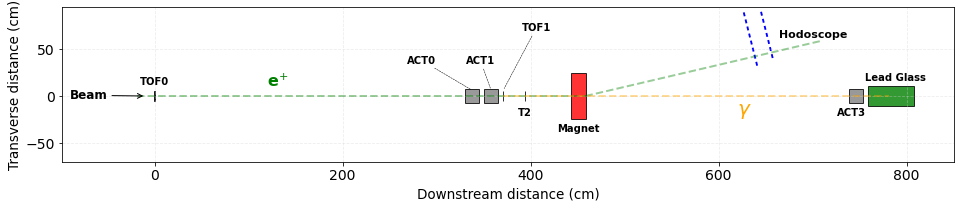

In [3]:
# Helper function to add a callout label
def add_callout_label(ax, point, end, label, labelsize, text_offset=(0,0)):
    ax.annotate(label, 
                xy=point,
                xytext=end,
                arrowprops=dict(arrowstyle='-',linestyle='--',linewidth=0.5,facecolor='black'), # adjust line width and color
                fontsize=labelsize,
                fontweight='bold')

# Detectors to be placed on the drawing
detectors = [
    {'label': 'TOF0', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 15, 'lzoffset': 0, 'center': (0, -450.9), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'ACT0', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -112.9), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'ACT1', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -92.9), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'TOF1', 'labelcallout': True, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 8, 'lzoffset': 0, 'center': (0, -80.1), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'T2',   'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -18, 'lzoffset': 0, 'center': (0, -56.9), 'x_length': 10, 'z_length': .6, 'color': 'black'},
    {'label': 'Magnet', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -35, 'lzoffset': 0, 'center': (0, 0), 'x_length': 48, 'z_length': 15, 'color': 'red'},
    {'label': 'ACT3', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': -18, 'lzoffset': -5, 'center': (0, 295.1), 'x_length': 15, 'z_length': 15, 'color': 'gray'},
    {'label': 'Lead Glass', 'labelcallout': False, 'labelsize': 10, 'labelrot': 0, 'lxoffset': 20, 'lzoffset': 5, 'center': (0, 332.35), 'x_length': 20.5, 'z_length': 49.5, 'color': 'green'}
]

xoffset = -450.9

fig, ax = plt.subplots(figsize=(16, 6))
fig.set_facecolor('white')

ax.set_xlim([-550-xoffset,400-xoffset])
ax.set_ylim([-70,95])

# Add gridlines
ax.grid(True, which='both', color='lightgray', alpha=0.4, linestyle='--')

# Add the detectors
for detector in detectors:
    y, x = detector['center']
    x_len, z_len = detector['x_length'], detector['z_length']
    rect = patches.Rectangle((x - z_len/2 - xoffset, y - x_len/2), z_len, x_len, 
                             edgecolor='black', facecolor=detector['color'], alpha=0.8)
    ax.add_patch(rect)
    
    if(not detector['labelcallout']):
        ax.text(x+detector['lzoffset']-xoffset, y+detector['lxoffset'], detector['label'], ha='center', 
                va='center', color='black', fontweight='bold', fontsize=detector['labelsize'], rotation=detector['labelrot'])

# Hodoscope label
ax.text(250-xoffset, 65, "Hodoscope", ha='center', va='center', color='black', fontweight='bold', fontsize=11)

# ACT0 callout label
point_ACT0 = (-112.9-xoffset, 6)
end_ACT0 = (-182.9-xoffset, 35)
add_callout_label(ax, point_ACT0, end_ACT0, "ACT0", detectors[1]['labelsize'], text_offset=(0,30))

# ACT1 callout label
point_ACT1 = (-92.9-xoffset, 6)
end_ACT1 = (-120-xoffset, 35)
add_callout_label(ax, point_ACT1, end_ACT1, "ACT1", detectors[2]['labelsize'], text_offset=(0,30))

# TOF1 callout label
point_TOF1 = (-80.1-xoffset,6)
end_TOF1 = (-60.1-xoffset,70)
add_callout_label(ax, point_TOF1, end_TOF1, "TOF1", detectors[3]['labelsize'], text_offset=(0,30))

# Beam annotation
ax.annotate("Beam", xy=(-10, 0), xytext=(-90, -3),
                arrowprops=dict(arrowstyle='->',facecolor='black'), # adjust line width and color
                fontsize=12,
                fontweight='bold')
    
# Add hodoscope elements and labels
labels_8 = [14, 12, 10, 8, 6, 4, 2, 0]
labels_7 = [13, 11, 9, 7, 5, 3, 1]

for i in range(8):  # First row
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_8[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_8[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x-xoffset, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=1.0)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = (draw_x-xoffset) + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

for i in range(7):  # Second row
    
    # Create a rectangle patch
    draw_x = hodoscope_positions[labels_7[i]][1] - end_of_magnet_offset - hodo_z_len/2
    draw_y = hodoscope_positions[labels_7[i]][0] - hodo_x_len/2
    rectangle = patches.Rectangle((draw_x-xoffset, draw_y),
                                  hodo_z_len, hodo_x_len, facecolor='blue', alpha=1.0)
    ax.add_patch(rectangle)
    
    # Rotate the rectangle
    center_x = (draw_x-xoffset) + hodo_z_len/2
    center_y = draw_y + hodo_x_len/2
    rotation = transforms.Affine2D().rotate_deg_around(center_x, center_y, np.degrees(0.23))
    rectangle.set_transform(rotation + ax.transData)

# ------------------------------------------------------------------------------------------------------
# Plot the e+ and gamma tracks

# e+ along the beam
x_values = np.zeros(100)
z_values = np.linspace(-470, 7.5, 100)
ax.plot(z_values-xoffset, x_values, linestyle='--', linewidth=2, alpha=0.4, color='green')
ax.annotate("e$^{+}$", xy=(120, 10), xytext=(120, 10), fontsize=16, fontweight='bold', color='green')

# e+ after interaction in the magnet.
p_particle = 300
theta = Bd / (p_particle * 1e6 / c)  # calculate the angle at which the particle exits the magnetic field
z_values = np.linspace(0, l_max, 100)
dX_values = z_values * np.tan(theta)
ax.plot(z_values-xoffset+7.5, dX_values, linestyle='--', linewidth=2, alpha=0.4, color='green')

# gamma path
x_values = np.zeros(100)
z_values = np.linspace(-80.1, 330, 100)
ax.plot(z_values-xoffset, x_values, linestyle='--', linewidth=2, alpha=0.4, color='orange')
ax.annotate("$\gamma$", xy=(320, 10), xytext=(620, -20), fontsize=20, fontweight='bold', color='orange')

# ------------------------------------------------------------------------------------------------------
    
# Add a legend
#ax.legend(fontsize=13)

# Add labels and title
ax.set_xlabel('Downstream distance (cm)',fontsize=13.5)
ax.set_ylabel('Transverse distance (cm)',fontsize=13.5)
#ax.set_title('Approx. electron trajectories for different momenta',fontsize=18)

# Equal aspect ratio
ax.set_aspect('equal')

# Set larger tick marks
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("beamline.pdf", bbox_inches='tight')

### Calculation of energy for each hodoscope position (for use in *fig.LG_calibration*)

In [4]:
momenta_c = {} # momentum of electron hitting center of hodoscope element
momenta_l, momenta_r = {}, {} # momentum of electron hitting left and right of hodoscope element
momenta_delta = {} # momentum difference between left and right of hodoscope element
for elem, (x, z) in hodoscope_positions.items():

    z -= end_of_magnet_offset*2
    
    # Calculate the angle theta
    theta_c = np.arctan2(x, z)
    theta_l = np.arctan2(x+hodo_x_len/2, z)
    theta_r = np.arctan2(x-hodo_x_len/2, z)

    # Calculate the momentum in GeV/c
    p_c = Bd * c / theta_c / 1e9  # convert to GeV/c from kg*m/s
    p_l = Bd * c / theta_l / 1e9
    p_r = Bd * c / theta_r / 1e9
    
    # Store the calculations
    momenta_c[elem] = p_c
    momenta_l[elem] = p_l
    momenta_r[elem] = p_r
    momenta_delta[elem] = p_r - p_l

In [5]:
# Electron momenta for hitting the center of each hodoscope element
momenta_c

{0: 0.14505761972430145,
 1: 0.15765162214954906,
 2: 0.15841928032448094,
 3: 0.17224439239729353,
 4: 0.17476691180208406,
 5: 0.19003867977964684,
 6: 0.19515181169509832,
 7: 0.21214808347586303,
 8: 0.221179035463847,
 9: 0.24026729458843601,
 10: 0.2554300209785521,
 11: 0.2771087392456521,
 12: 0.3023374084001211,
 13: 0.3273027027261406,
 14: 0.37021942607830755}

In [6]:
print("Approx. momentum range due to size of hodoscope elements:")
for elem in momenta_c.keys():
    p_deltac = momenta_delta[elem]/momenta_c[elem]
    print("-- Elem {}, range = {}, range/mean = {}".format(elem,momenta_delta[elem],p_deltac))

Approx. momentum range due to size of hodoscope elements:
-- Elem 0, range = 0.006003478040787047, range/mean = 0.0413868506335437
-- Elem 1, range = 0.00663729973711355, range/mean = 0.04210105577484878
-- Elem 2, range = 0.00736537624991454, range/mean = 0.046492928353344815
-- Elem 3, range = 0.008107593837929694, range/mean = 0.04707029195603055
-- Elem 4, range = 0.009190736655809384, range/mean = 0.05258853956415671
-- Elem 5, range = 0.010071346615116883, range/mean = 0.05299629857876715
-- Elem 6, range = 0.011710541962637738, range/mean = 0.060007344338335315
-- Elem 7, range = 0.01277173351075328, range/mean = 0.06020197449583076
-- Elem 8, range = 0.015319172071836973, range/mean = 0.06926141096379354
-- Elem 9, range = 0.016621962079086255, range/mean = 0.06918112640989577
-- Elem 10, range = 0.020735616861404627, range/mean = 0.08117924738042342
-- Elem 11, range = 0.022370514673047126, range/mean = 0.08072829003496729
-- Elem 12, range = 0.02938524946620763, range/mean = 

# 2. Plots of magnetic field map

In [7]:
# Read the field map.
df = pd.read_csv('mfMapMeasured.txt', delim_whitespace=True, comment='%', header=None)

# Assign column names
df.columns = ['x', 'y', 'z', 'Bx', 'By', 'Bz']

# Compute the magnitude of the field
df['Bmag'] = np.sqrt(df['Bx']**2 + df['By']**2 + df['Bz']**2)

df.head(20)

x     y      z   Bx   By   Bz  Bmag
0  -15.0 -15.0 -315.0  0.0  0.0  0.0   0.0
1  -12.5 -15.0 -315.0  0.0  0.0  0.0   0.0
2  -10.0 -15.0 -315.0  0.0  0.0  0.0   0.0
3   -7.5 -15.0 -315.0  0.0  0.0  0.0   0.0
4   -5.0 -15.0 -315.0  0.0  0.0  0.0   0.0
5   -2.5 -15.0 -315.0  0.0  0.0  0.0   0.0
6    0.0 -15.0 -315.0  0.0  0.0  0.0   0.0
7    2.5 -15.0 -315.0  0.0  0.0  0.0   0.0
8    5.0 -15.0 -315.0  0.0  0.0  0.0   0.0
9    7.5 -15.0 -315.0  0.0  0.0  0.0   0.0
10  10.0 -15.0 -315.0  0.0  0.0  0.0   0.0
11  12.5 -15.0 -315.0  0.0  0.0  0.0   0.0
12  15.0 -15.0 -315.0  0.0  0.0  0.0   0.0
13 -15.0 -12.5 -315.0  0.0  0.0  0.0   0.0
14 -12.5 -12.5 -315.0  0.0  0.0  0.0   0.0
15 -10.0 -12.5 -315.0  0.0  0.0  0.0   0.0
16  -7.5 -12.5 -315.0  0.0  0.0  0.0   0.0
17  -5.0 -12.5 -315.0  0.0  0.0  0.0   0.0
18  -2.5 -12.5 -315.0  0.0  0.0  0.0   0.0
19   0.0 -12.5 -315.0  0.0  0.0  0.0   0.0

#### 1D plot (*fig.fieldmap*)

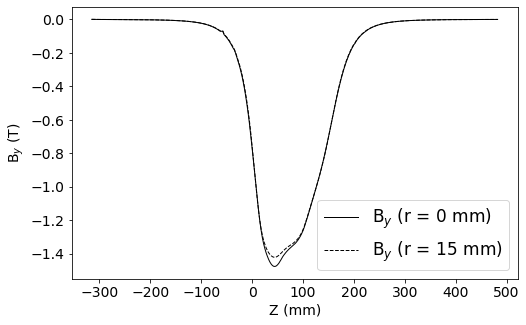

In [8]:
df_center = df[(df['y'] == 0) & (df['x'] == 0)]
df_r1 = df[(df['y'] == 0) & (df['x'] == 15.0)]

# Central axis
By_center = df_center['By'].values
z_center  = df_center['z'].values

# Off-axis near smallest bore edge
By_r1 = df_r1['By'].values
z_r1  = df_r1['z'].values

plt.figure(figsize=(8,5))
plt.plot(z_center,By_center,linewidth=1,color='black',label="B$_y$ (r = 0 mm)")
plt.plot(z_r1,By_r1,linewidth=1,color='black',linestyle='--',label="B$_y$ (r = 15 mm)")
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)
plt.xlabel('Z (mm)',fontsize=14)
plt.ylabel('B$_{y}$ (T)',fontsize=14)
plt.legend(fontsize=17,loc=4)
plt.savefig("Bfieldmap_axial.pdf")

# 3. Waveform analysis (*fig.waveform*)

In [9]:
import json5
import sys
sys.path.append("..")
import waveform_analysis as wf

In [10]:
# Open the run file and config file.
run_file = uproot.open("root_run_000735.root")
config = json5.load(open("../../../config/config_hodoscope.json"))['WaveAnalysis']

# Load the waveforms for HD14.
waveforms_HD14 = run_file['midas_data_D302']['Channel7'].array().to_numpy()

# Run the analysis of the waveforms.
analysis = wf.WaveformAnalysis(waveforms_HD14,
                            threshold=config["Thresholds"][0],
                            analysis_window=(config["AnalysisWindowLow"][0], config["AnalysisWindowHigh"][0]),
                            pedestal_window=(config["PedestalWindowLow"][0], config["PedestalWindowHigh"][0]),
                            reverse_polarity=(config["Polarity"][0]==0),
                            voltage_scale=config["VoltageScale"],
                            time_offset=config["TimeOffset"][0])
analysis.find_all_peak_voltages()

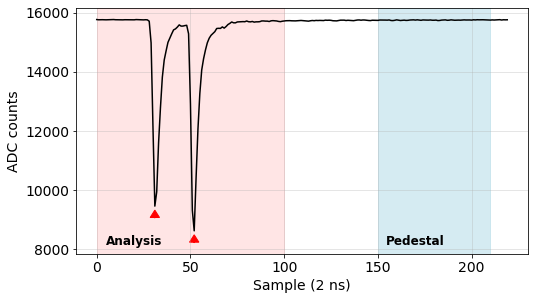

In [11]:
evt = 20675
base_dir = "plt_waveforms"

fig, axs = plt.subplots(1, 1, figsize=(7,4))
fig.tight_layout()
axs.plot(waveforms_HD14[evt][0:220],color='black')
#plt.title(f"")

# Iterate over peak times and plot arrows
for peak in analysis.pulse_peak_times[evt]:

    # Divide out the 2 ns / sample.
    peak_sample = int(peak/2)
    
    # Get the corresponding ADC count for the peak time
    y_peak = waveforms_HD14[evt][int(peak/2)]
    
    # Plot the arrow. The -5 in dy is arbitrary and used to offset the arrow tip for visibility.
    axs.arrow(peak_sample, y_peak-400, 0, 15, head_width=5, head_length=250, fc='red', ec='red')

axs.grid(alpha=0.4)
axs.set_xlabel("Sample (2 ns)",fontsize=14)
axs.set_ylabel("ADC counts",fontsize=14)
axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)

# Label the different regions
axs.axvspan(0, 100, color='red', alpha=0.1)
axs.axvspan(150, 210, color='lightblue', alpha=0.5)
axs.text(20, 8500, 'Analysis', ha='center', va='top', fontsize=12, fontweight='bold', color='black')
axs.text(170, 8500, 'Pedestal', ha='center', va='top', fontsize=12, fontweight='bold', color='black')

out_dir = f"{base_dir}/HD14"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
plt.savefig(f"{out_dir}/wf_HD14_{evt}.pdf", bbox_inches='tight')
#plt.close()

# 3. Gamma peak analysis

In [28]:
ntuple_pd_dir = "/Users/jrenner/local/jerenner/T9BeamTestAna/ntuple_dataframes/"

runs = [731, 732, 733, 734, 735, 736, 737, 738, 753, 754, 755, 756, 760, 763, 764, 765]
rmomenta = [460, 500, 600, 700, 800, 900, 1000, 1200, 500, 600, 700, 800, 1000, 900, 1200, 800]

ecal_m = 1.86e-2
ecal_b = -1.89

## 3a. Multi-run analysis

Processing run 731 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/jrenner/local/jerenner/T9BeamTestAna/python/new_analysis/hodoscope/hodoscope_functions_win.py:815: RuntimeWarning: invalid value encountered in sqrt
  lg_sigmas_MeV = (fit_sigmas_MeV**2 - (momentum_sigmas*1000)**2)**0.5


Processing run 732 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/jrenner/local/jerenner/T9BeamTestAna/python/new_analysis/hodoscope/hodoscope_functions_win.py:815: RuntimeWarning: invalid value encountered in sqrt
  lg_sigmas_MeV = (fit_sigmas_MeV**2 - (momentum_sigmas*1000)**2)**0.5


Processing run 733 ...


/Users/jrenner/local/jerenner/T9BeamTestAna/python/new_analysis/hodoscope/hodoscope_functions_win.py:815: RuntimeWarning: invalid value encountered in sqrt
  lg_sigmas_MeV = (fit_sigmas_MeV**2 - (momentum_sigmas*1000)**2)**0.5


Processing run 734 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/jrenner/local/jerenner/T9BeamTestAna/python/new_analysis/hodoscope/hodoscope_functions_win.py:815: RuntimeWarning: invalid value encountered in sqrt
  lg_sigmas_MeV = (fit_sigmas_MeV**2 - (momentum_sigmas*1000)**2)**0.5


Processing run 735 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Processing run 736 ...
Processing run 737 ...
Processing run 738 ...
Processing run 753 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/jrenner/local/jerenner/T9BeamTestAna/python/new_analysis/hodoscope/hodoscope_functions_win.py:815: RuntimeWarning: invalid value encountered in sqrt
  lg_sigmas_MeV = (fit_sigmas_MeV**2 - (momentum_sigmas*1000)**2)**0.5


Processing run 754 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/jrenner/local/jerenner/T9BeamTestAna/python/new_analysis/hodoscope/hodoscope_functions_win.py:815: RuntimeWarning: invalid value encountered in sqrt
  lg_sigmas_MeV = (fit_sigmas_MeV**2 - (momentum_sigmas*1000)**2)**0.5


Processing run 755 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/jrenner/local/jerenner/T9BeamTestAna/python/new_analysis/hodoscope/hodoscope_functions_win.py:815: RuntimeWarning: invalid value encountered in sqrt
  lg_sigmas_MeV = (fit_sigmas_MeV**2 - (momentum_sigmas*1000)**2)**0.5


Processing run 756 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Processing run 760 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Processing run 763 ...
Processing run 764 ...
Processing run 765 ...


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


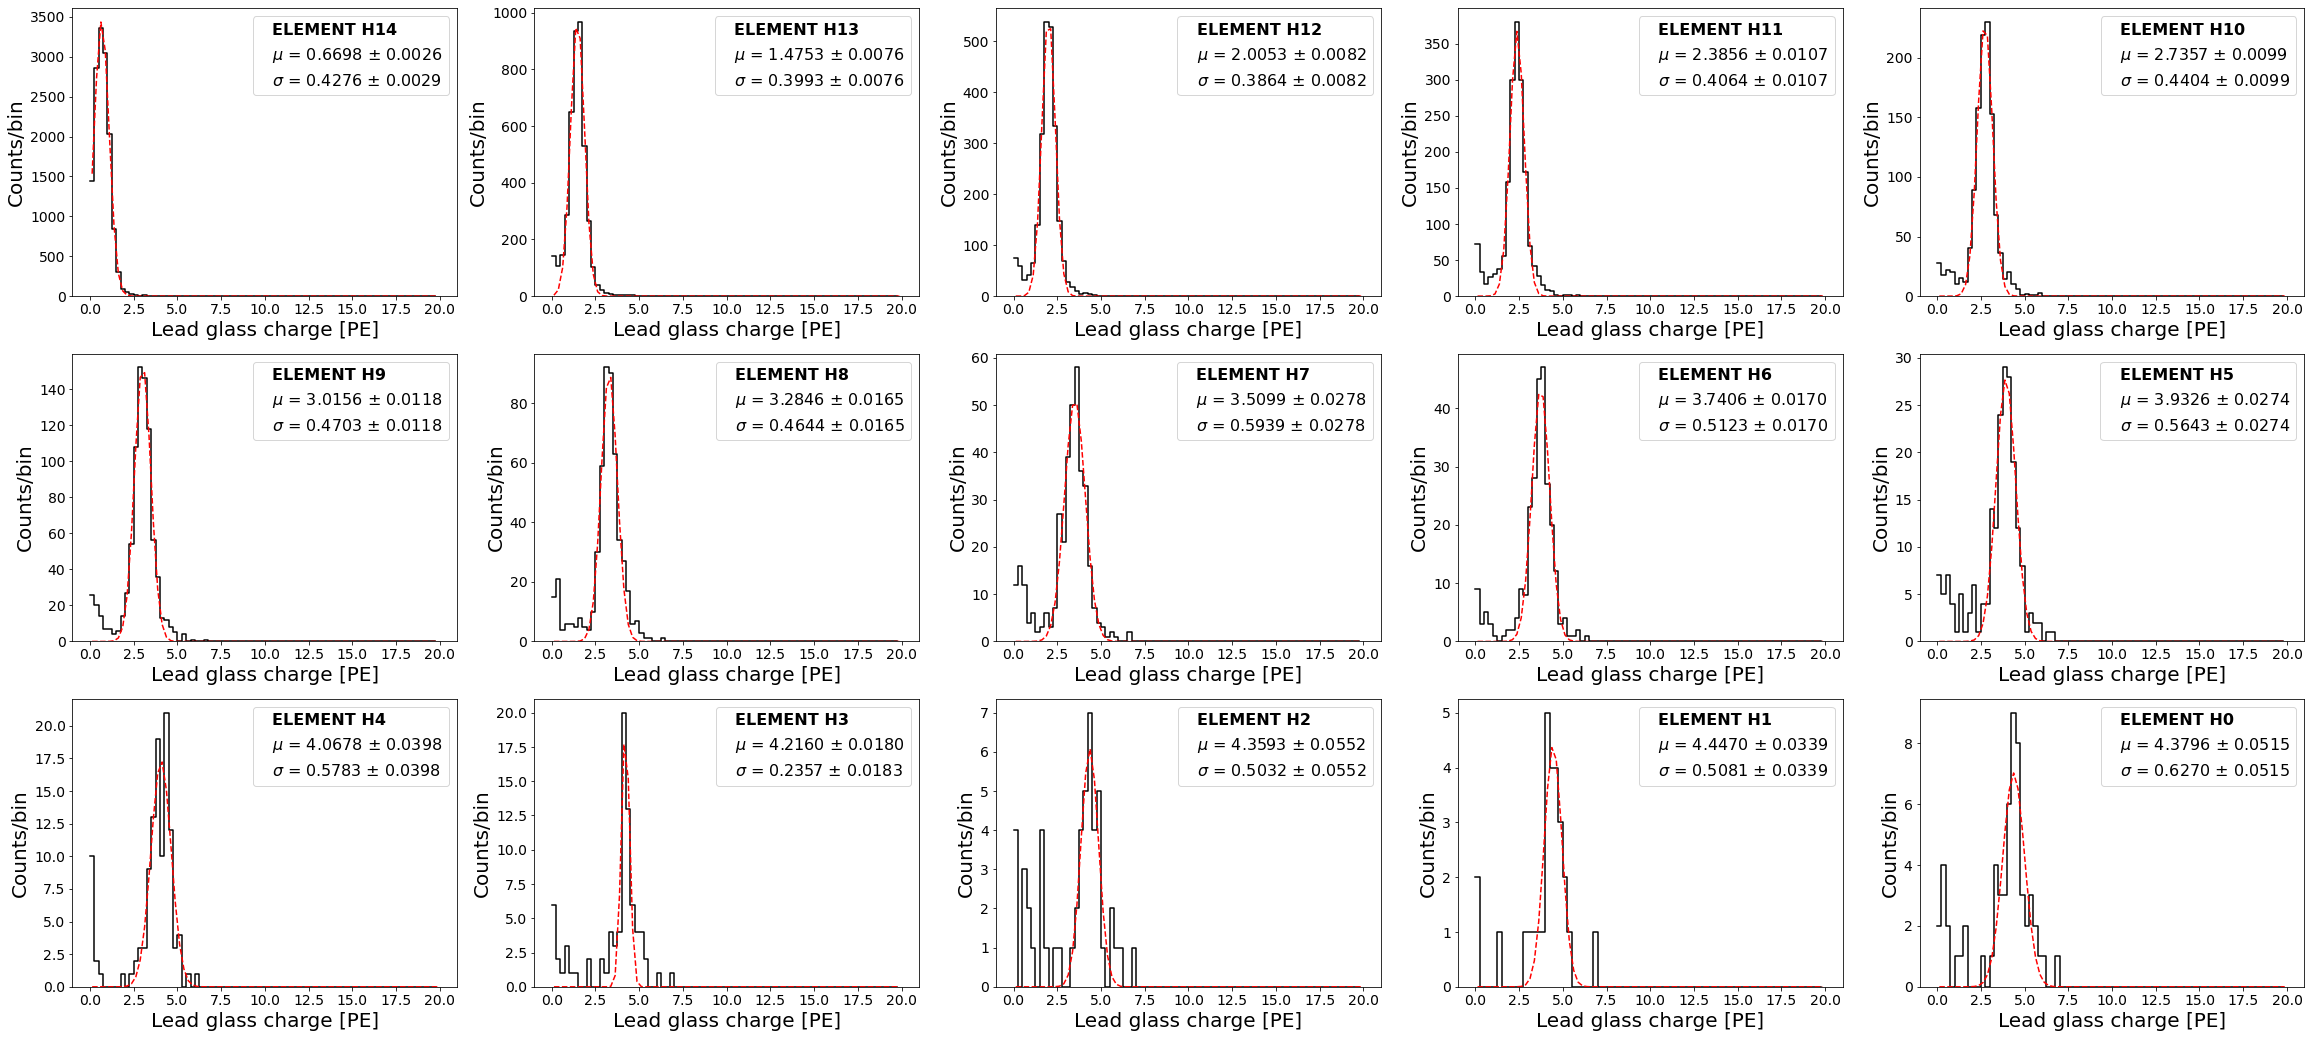

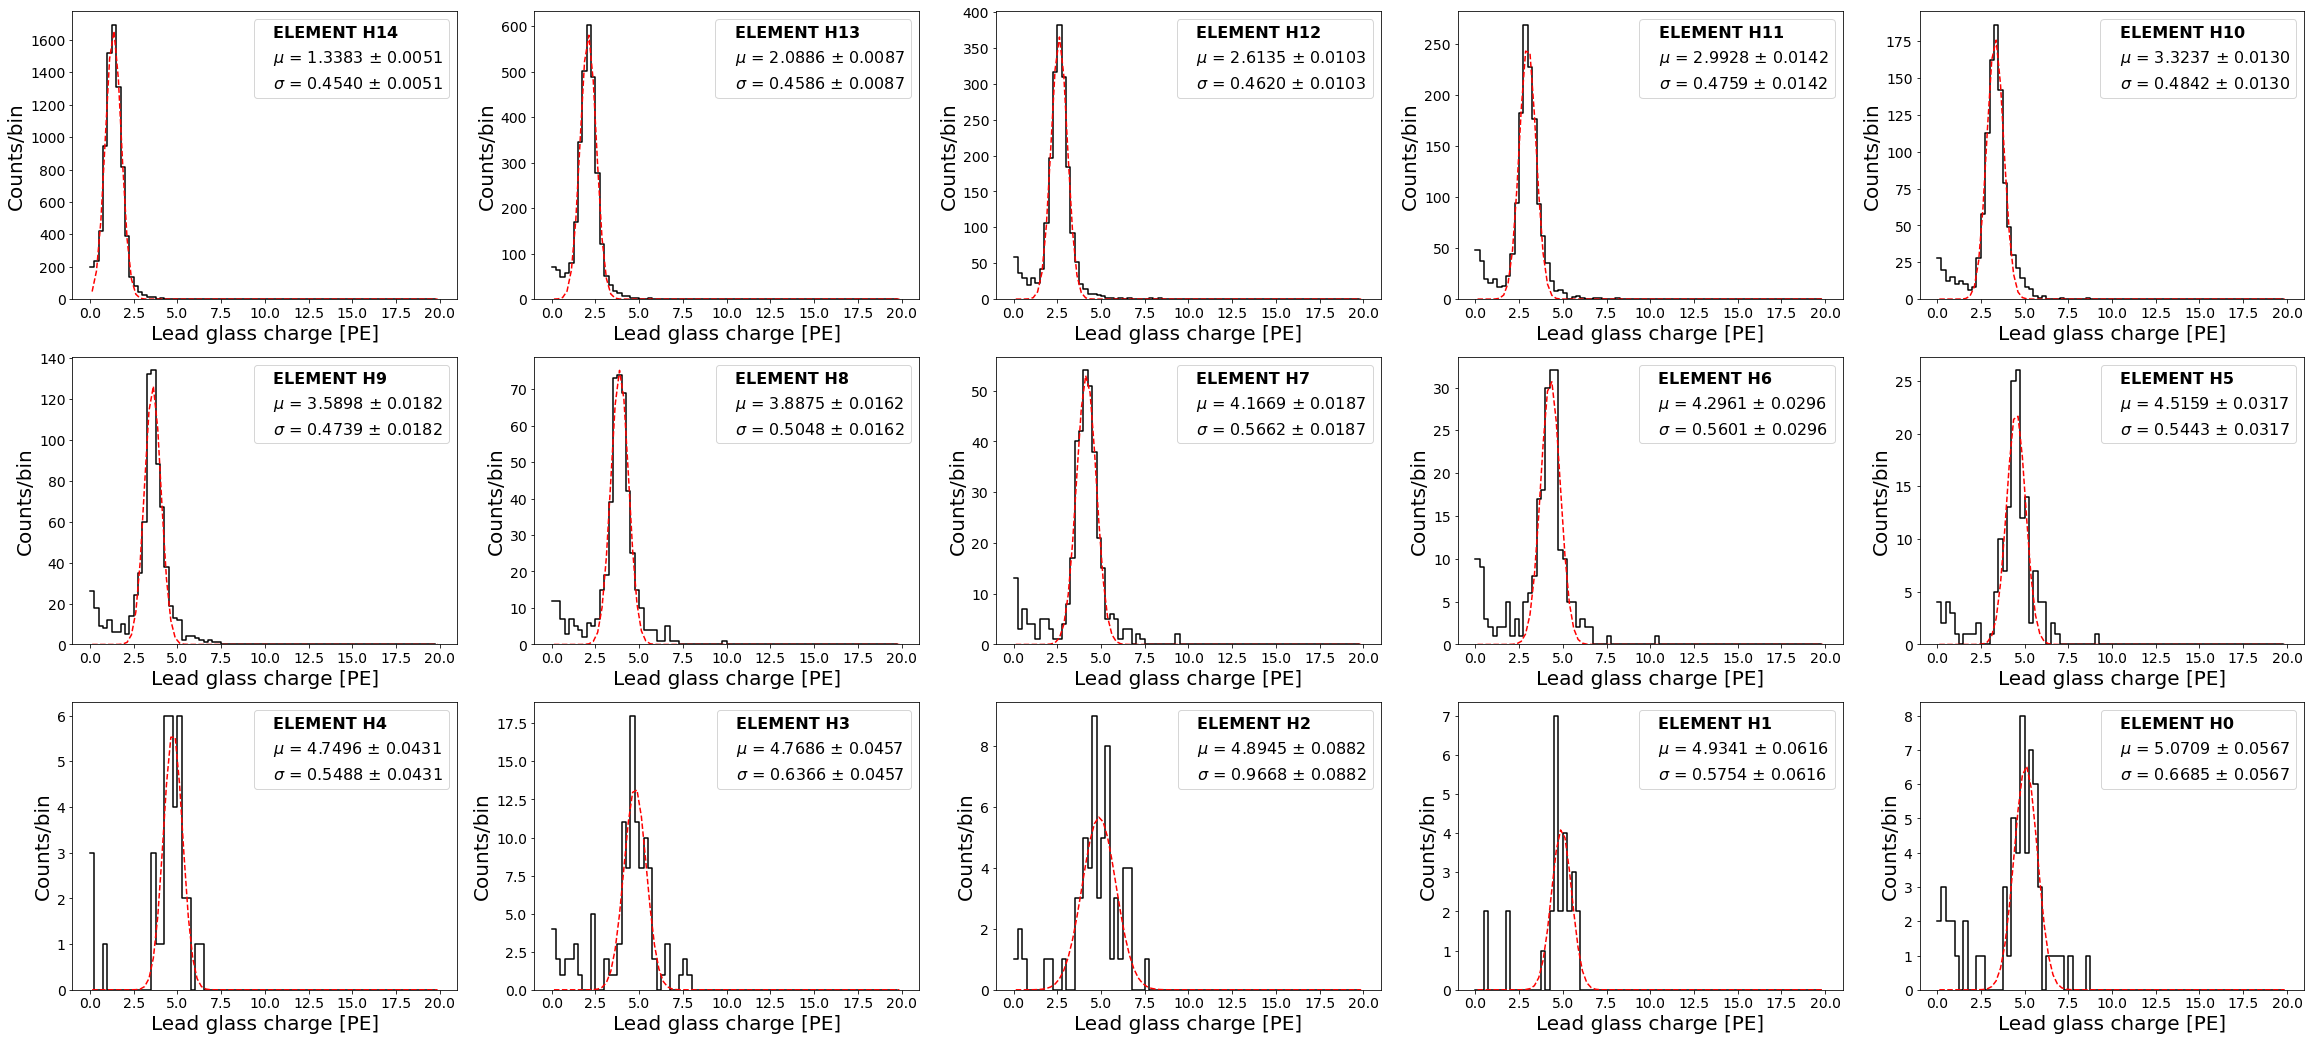

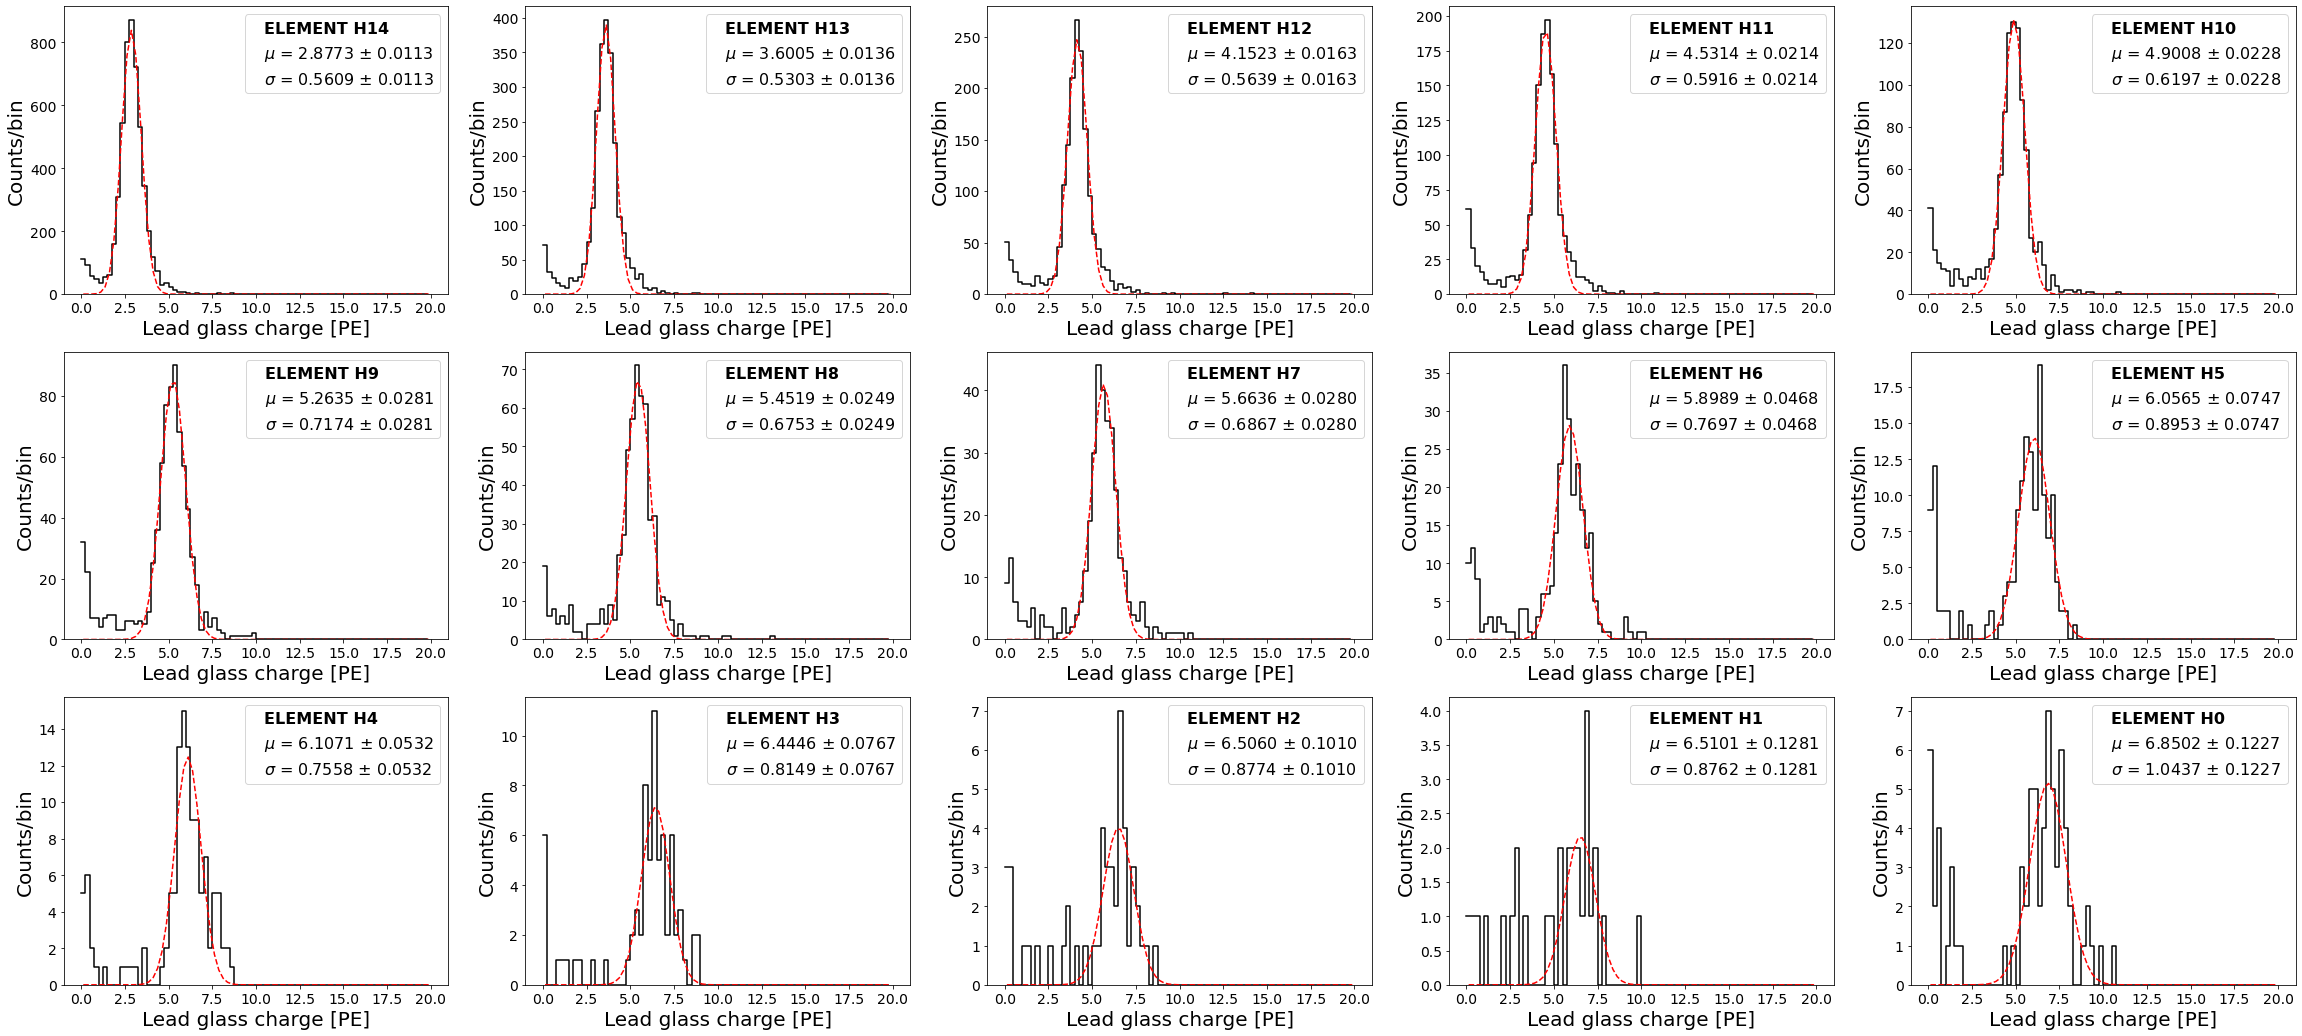

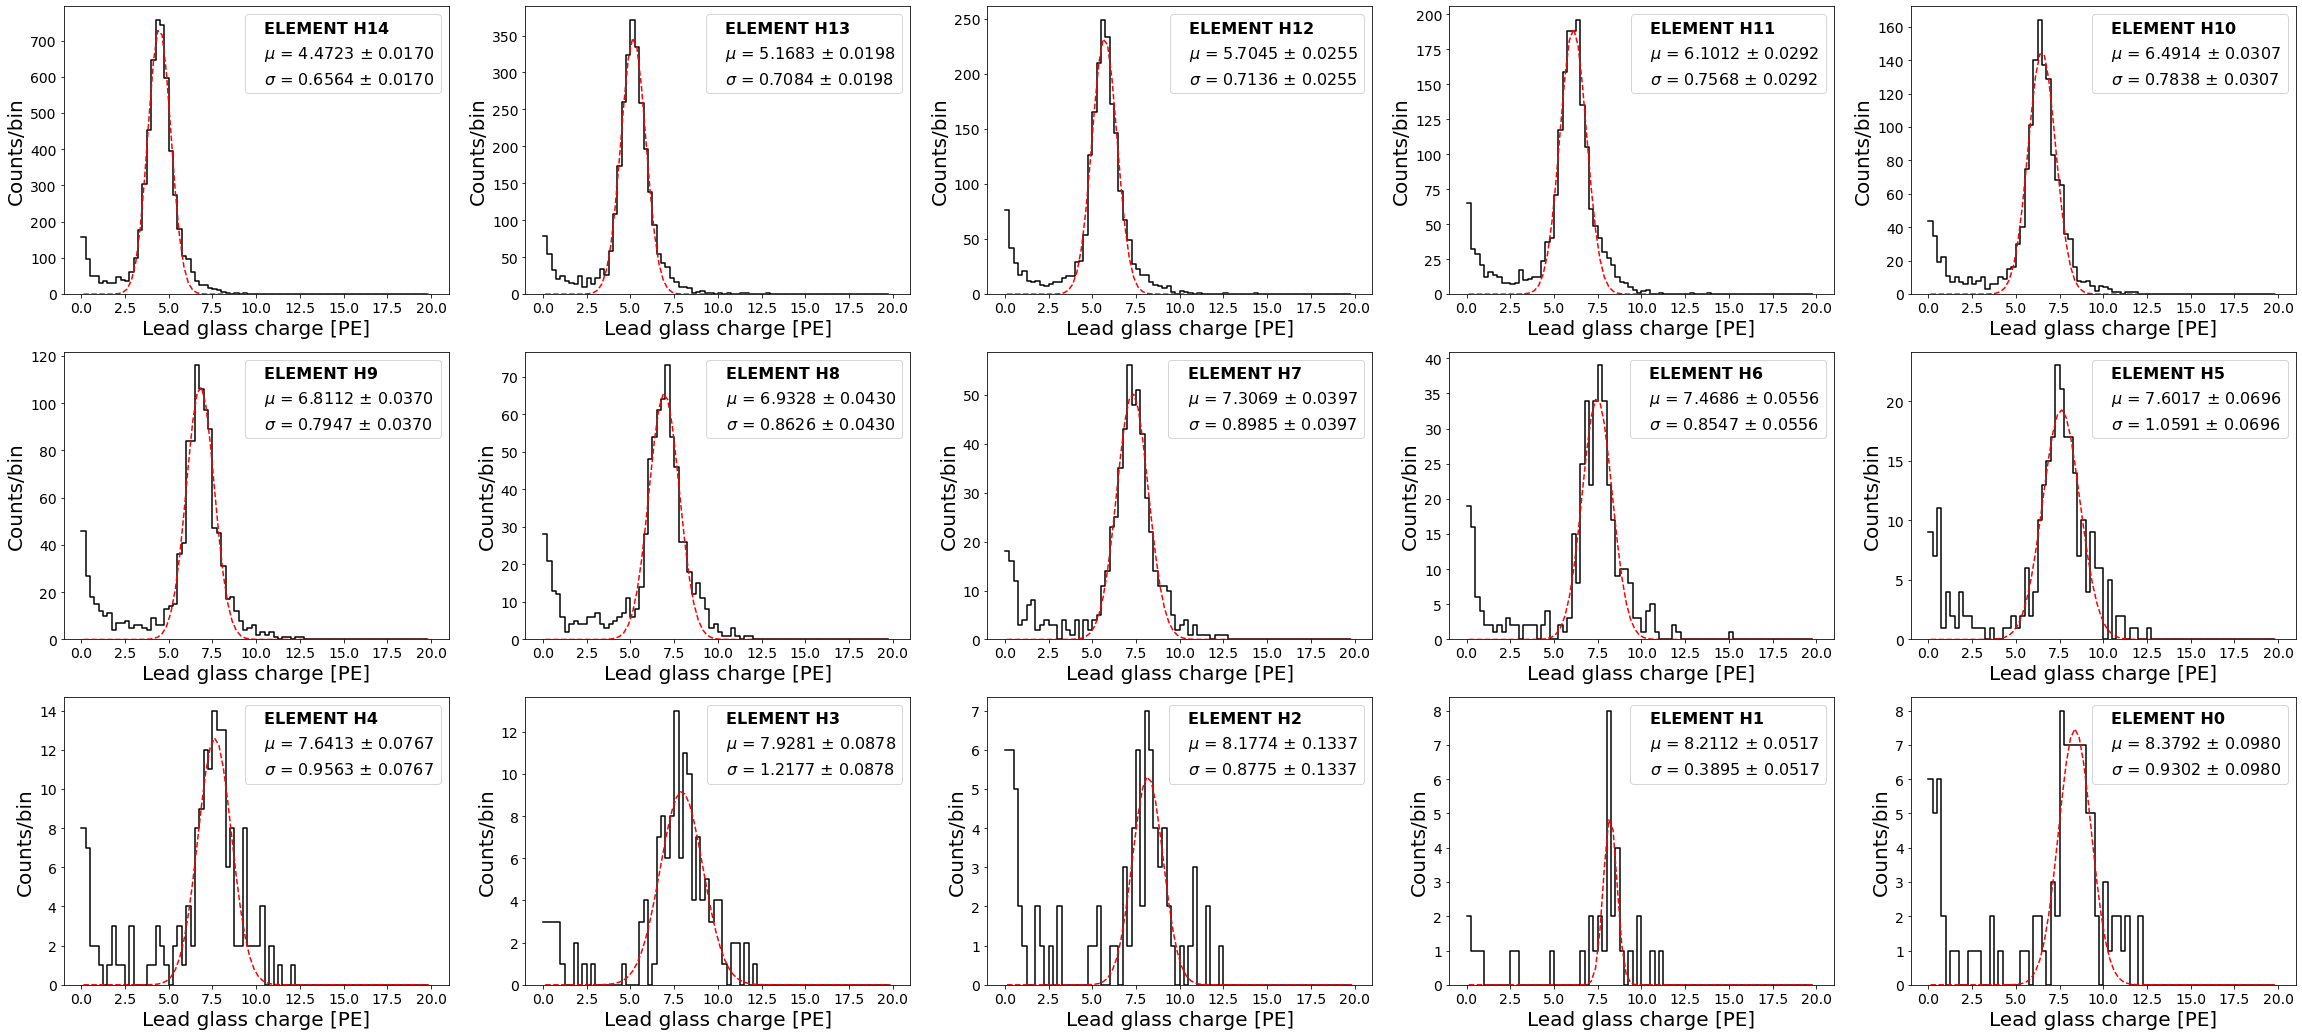

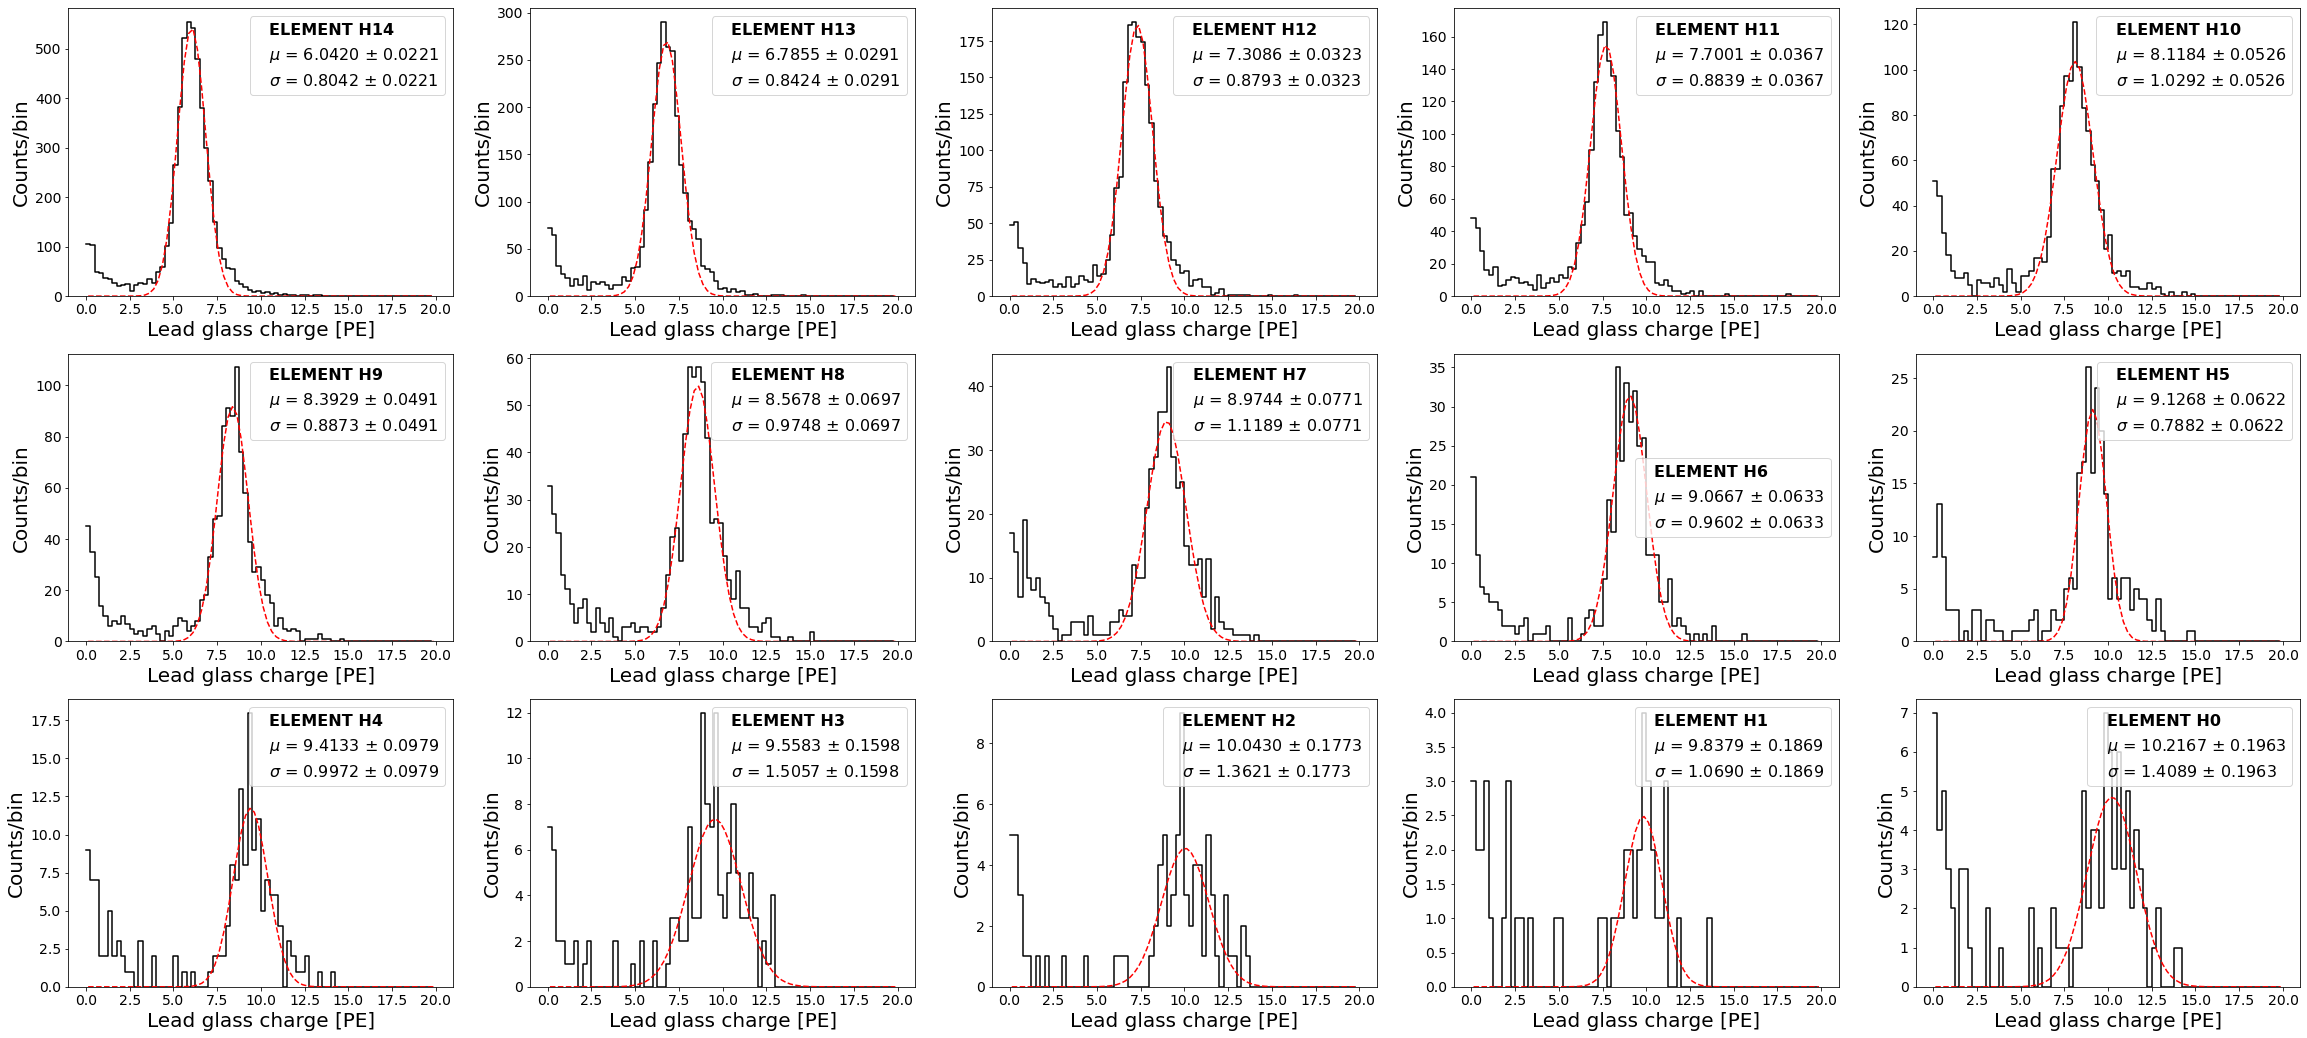

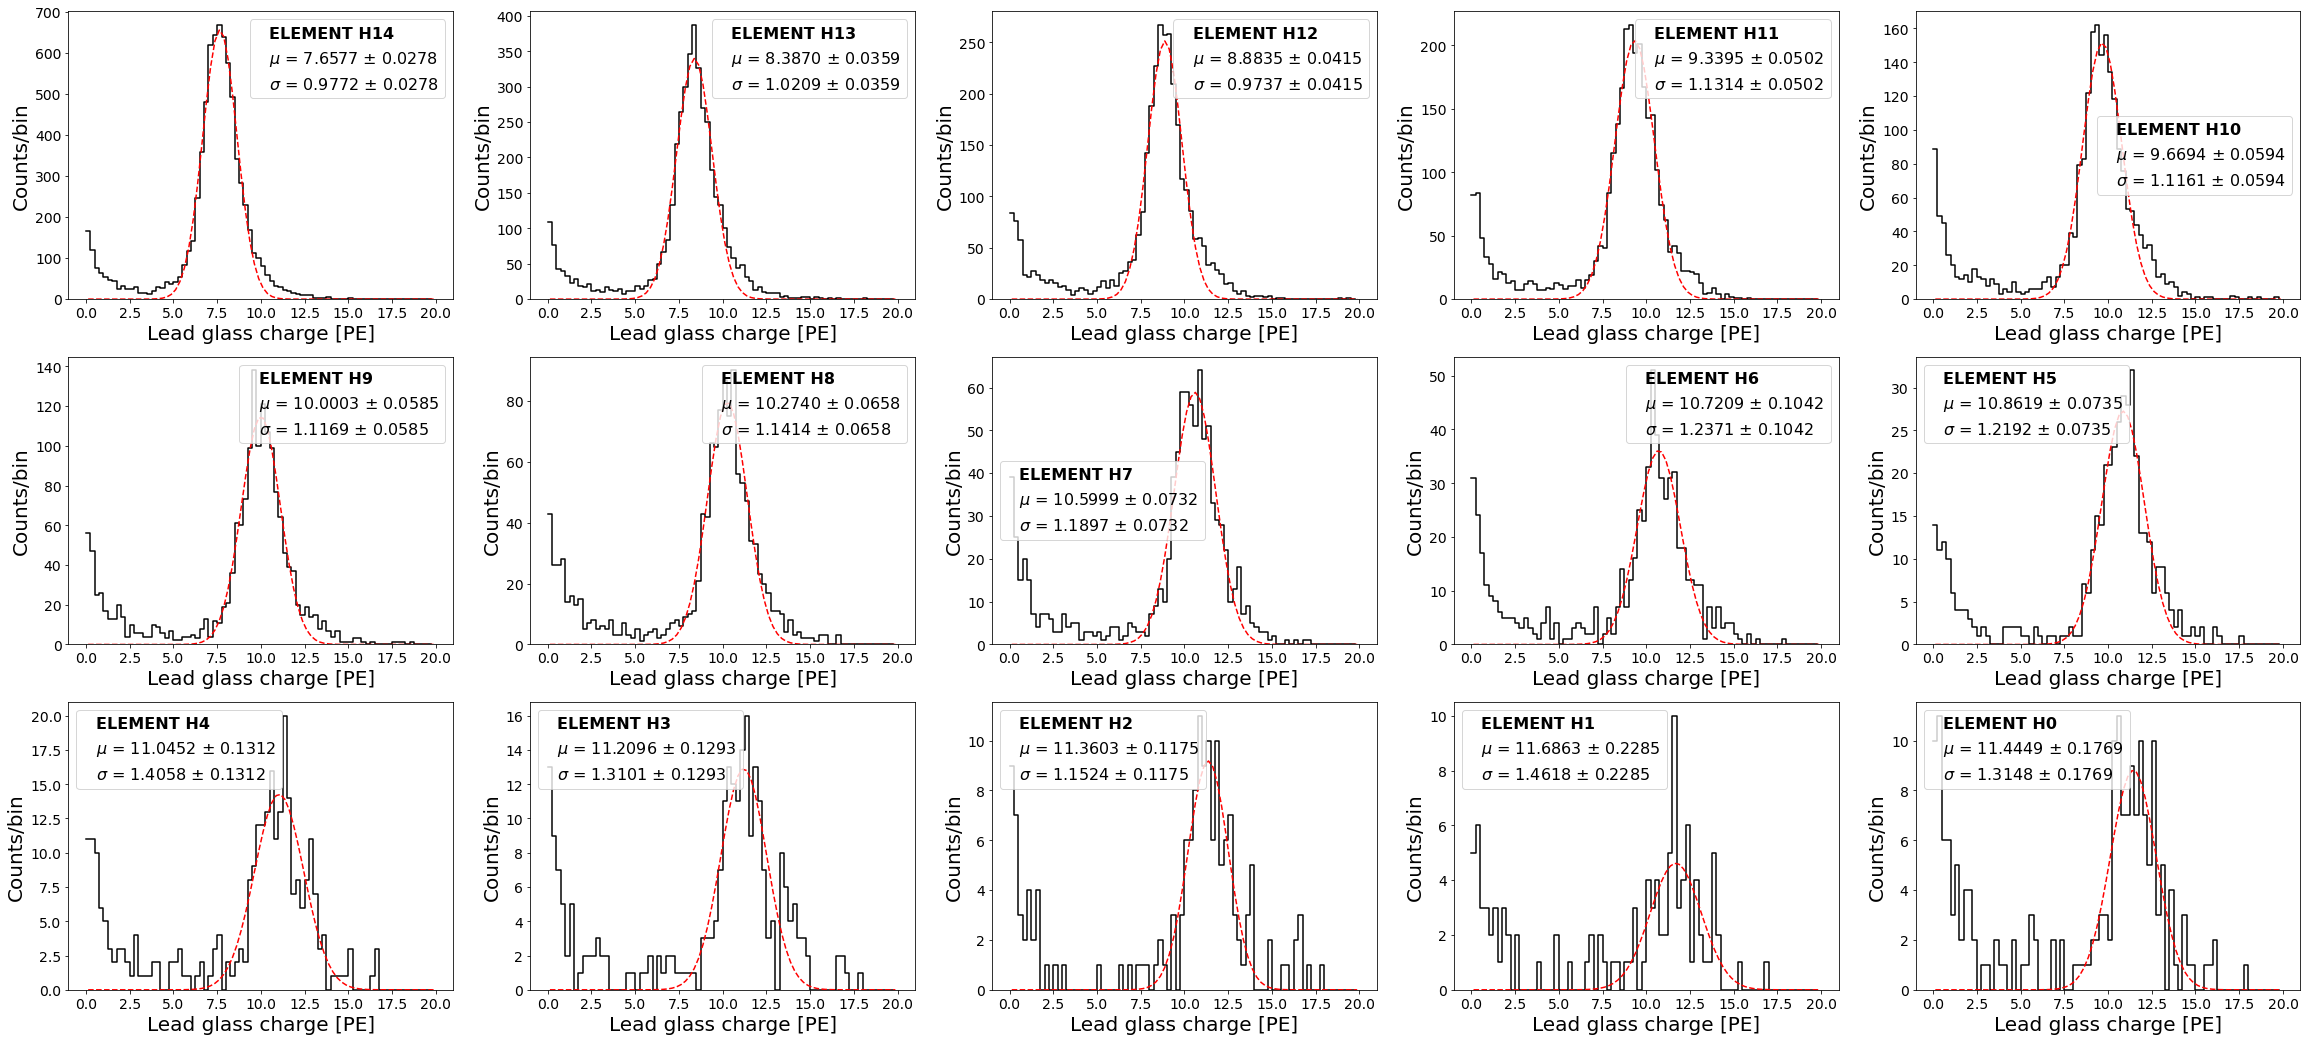

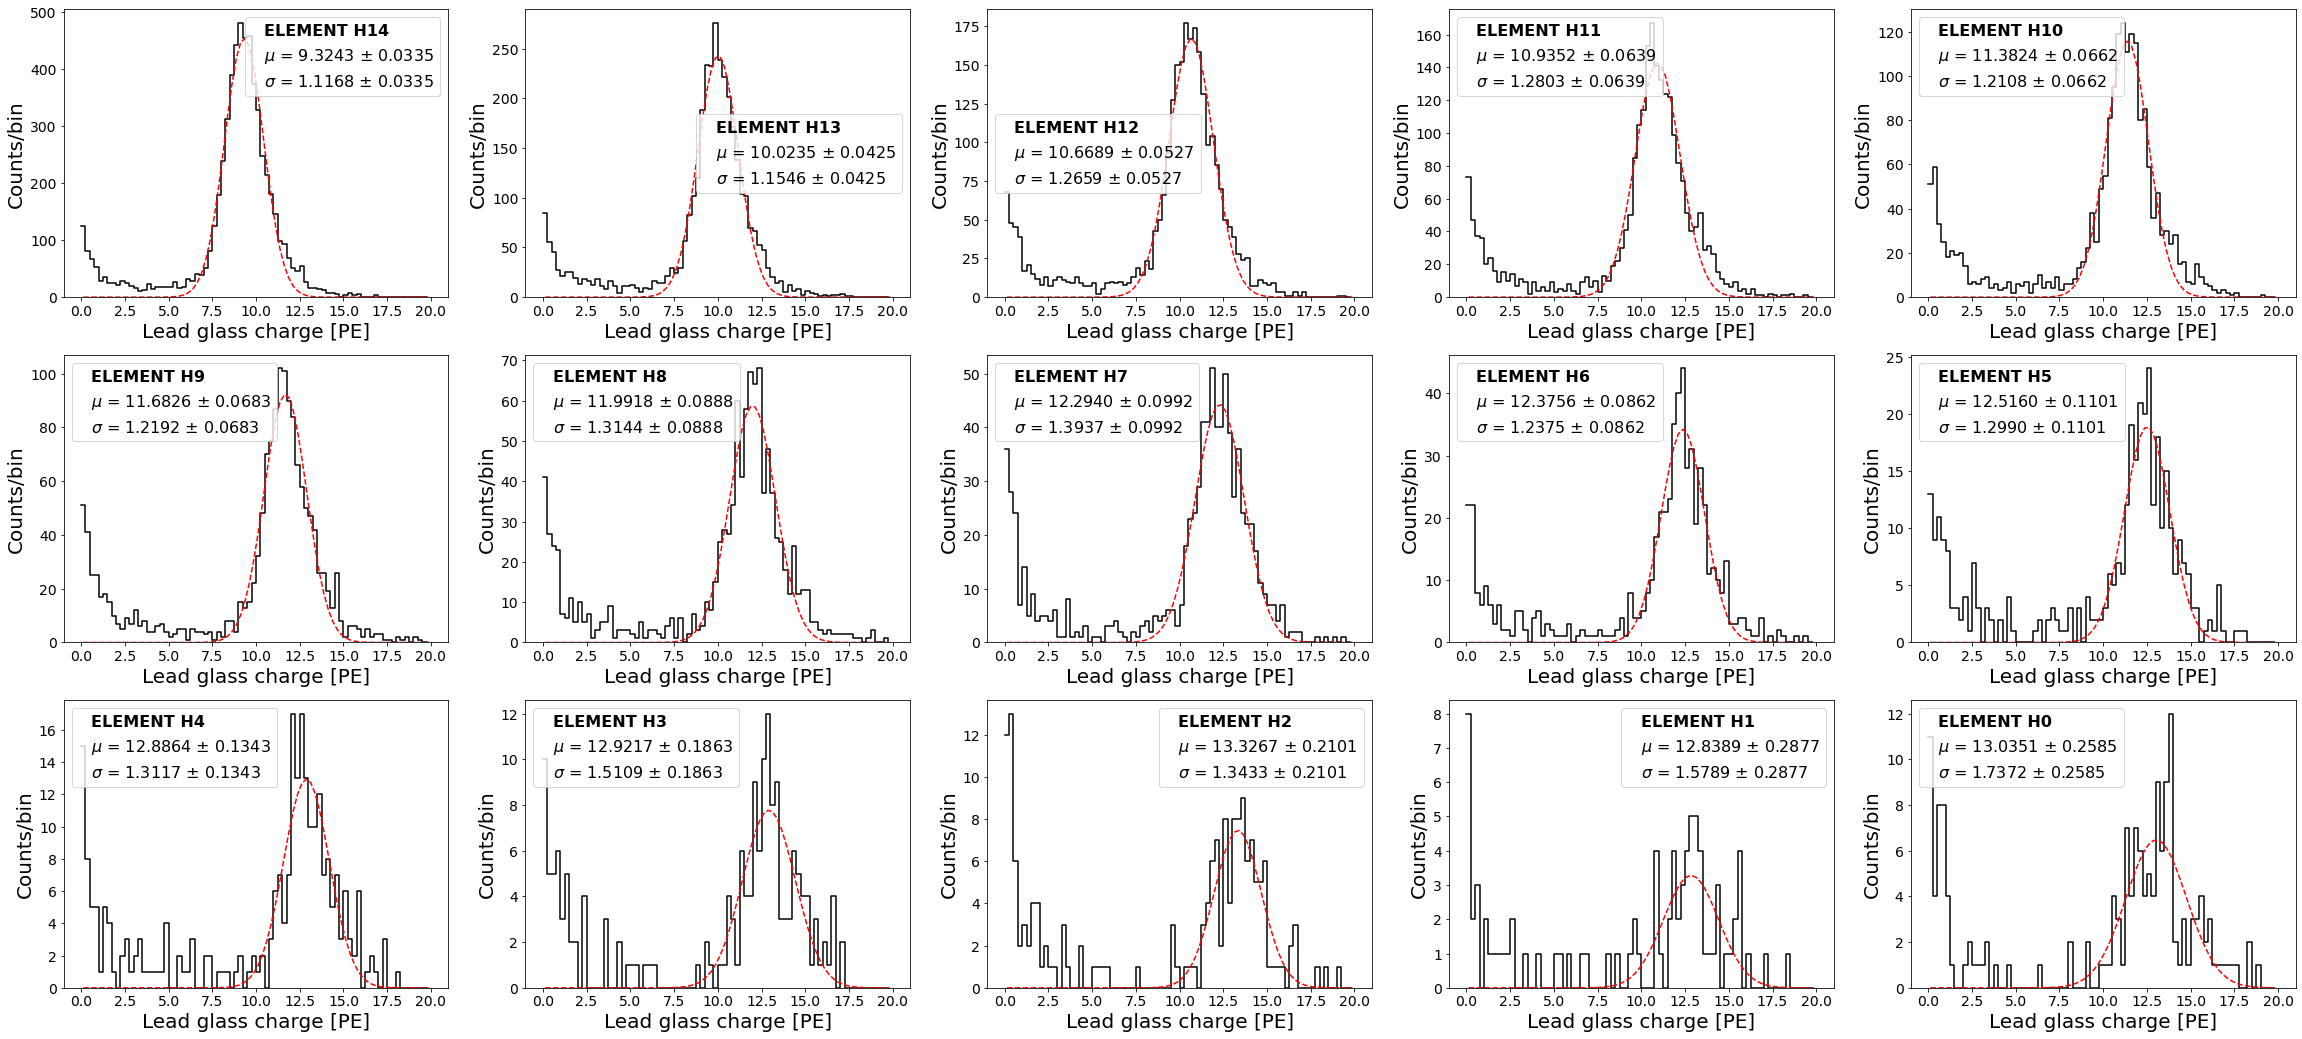

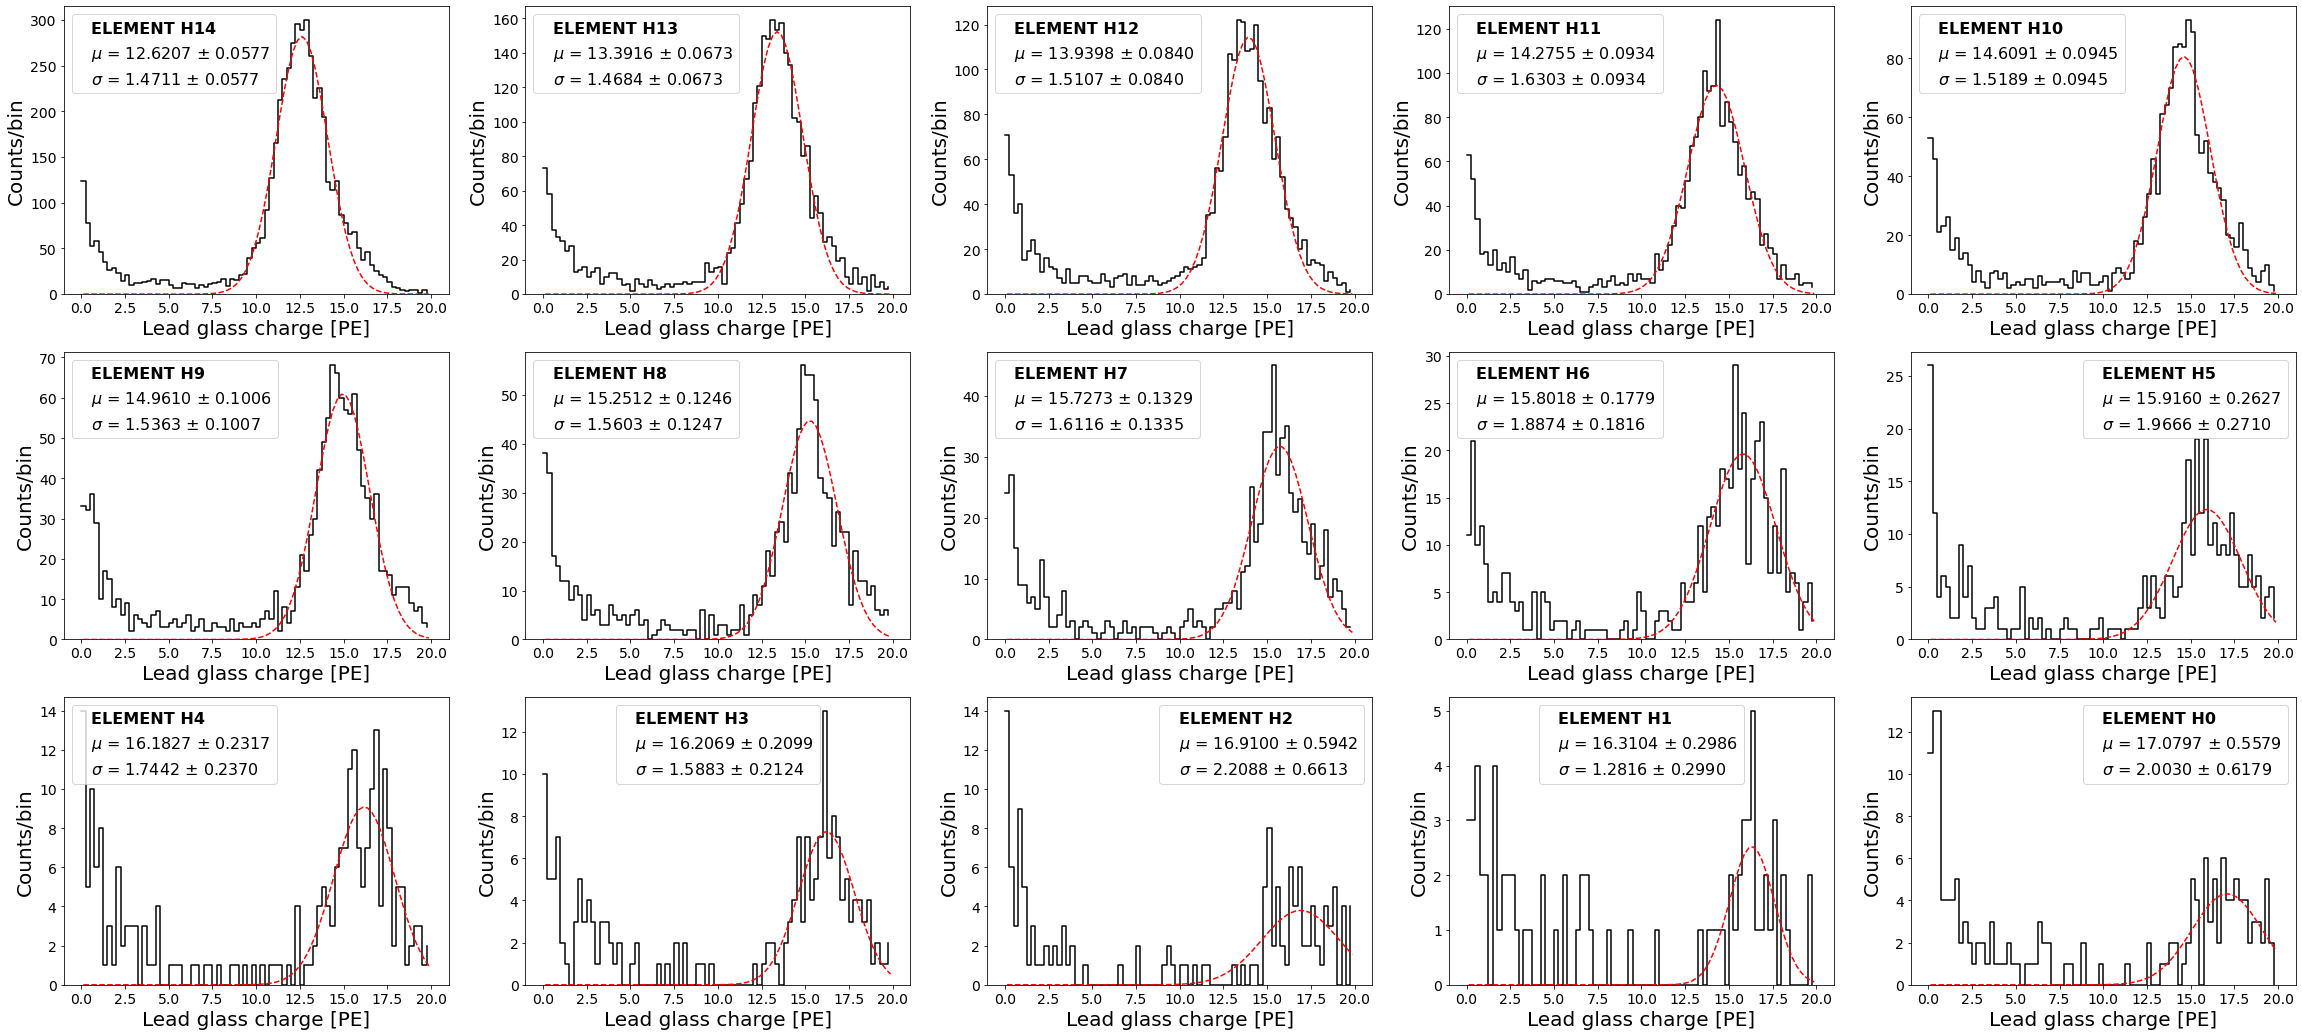

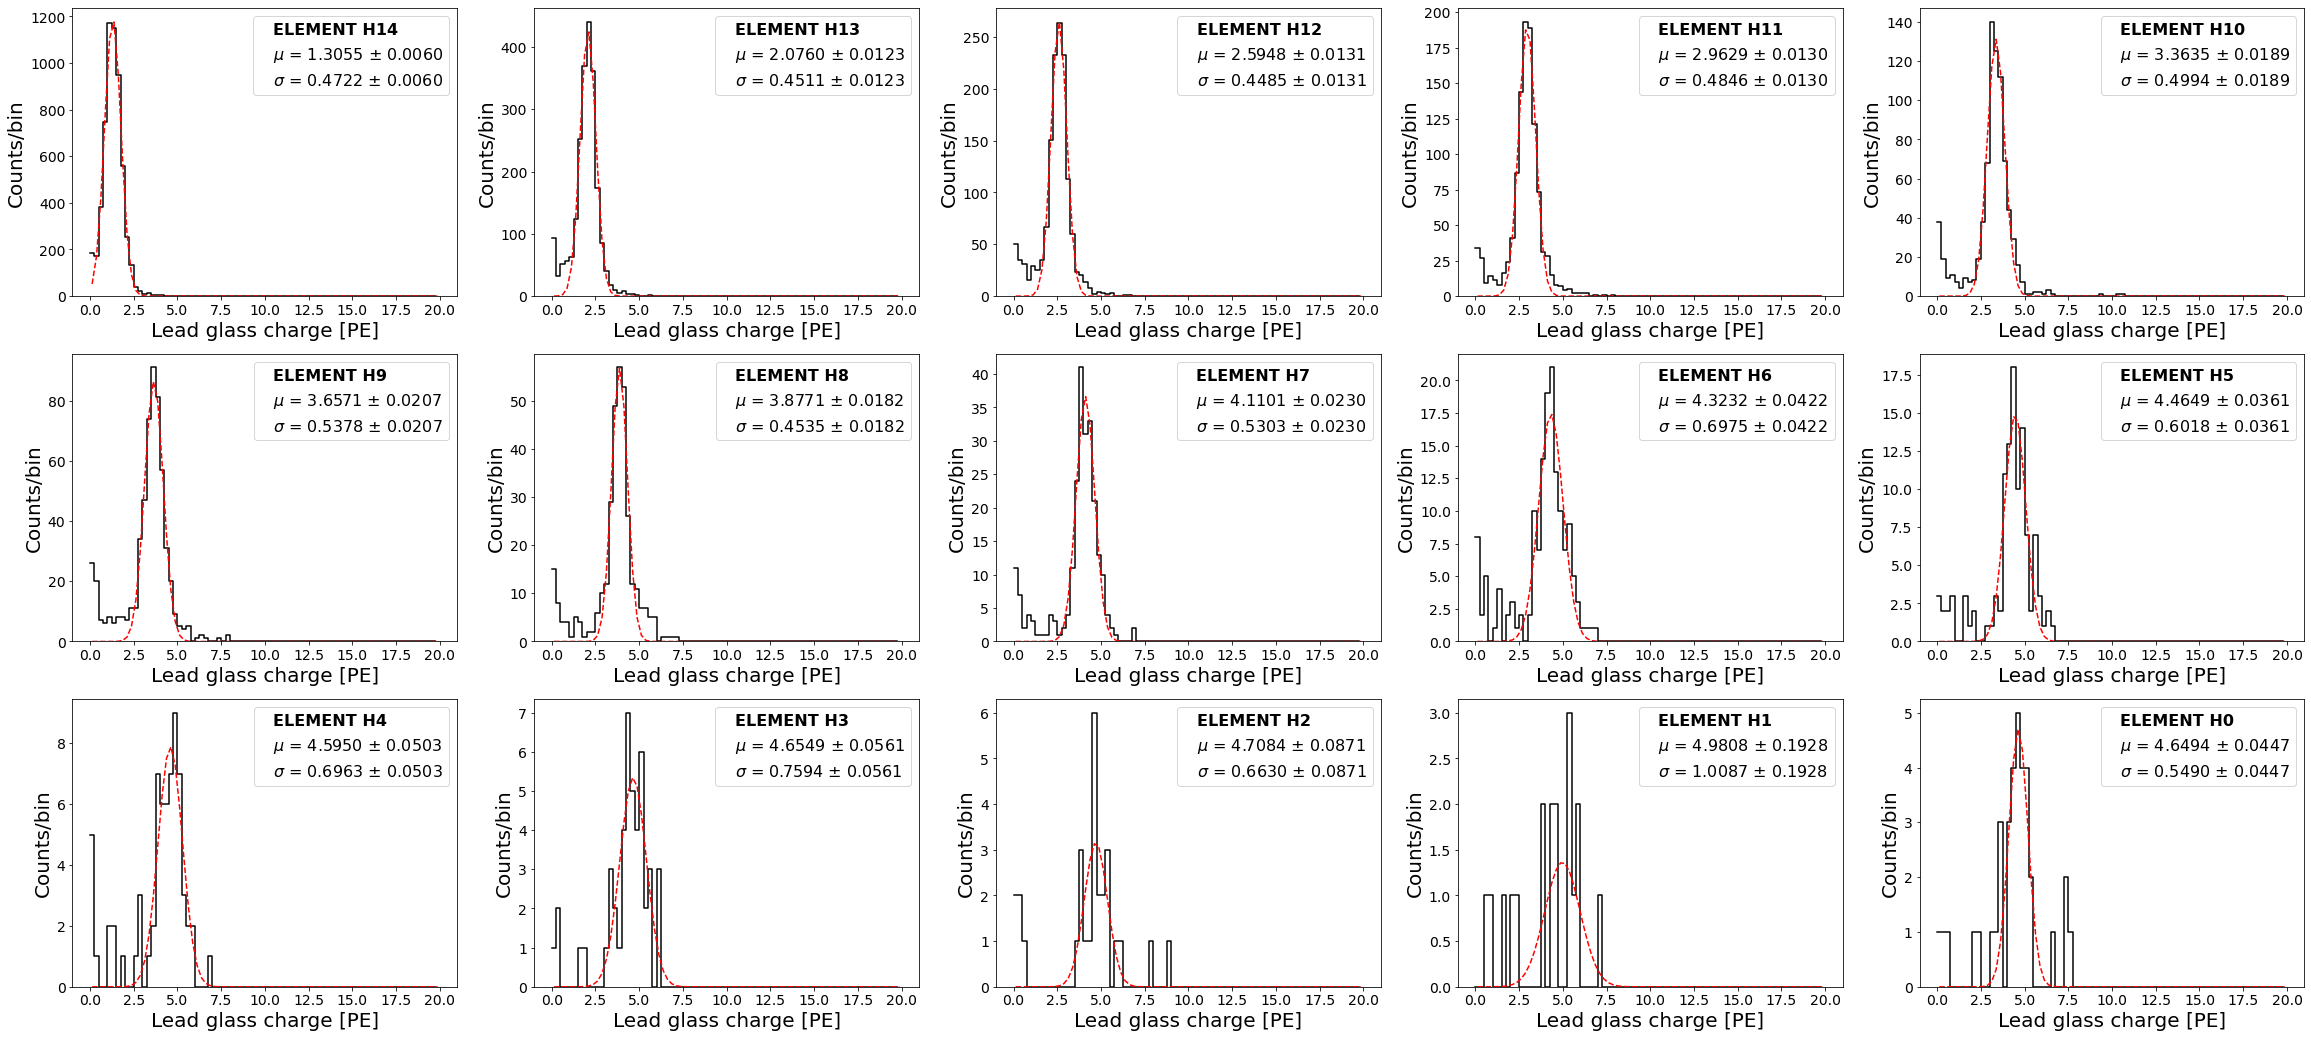

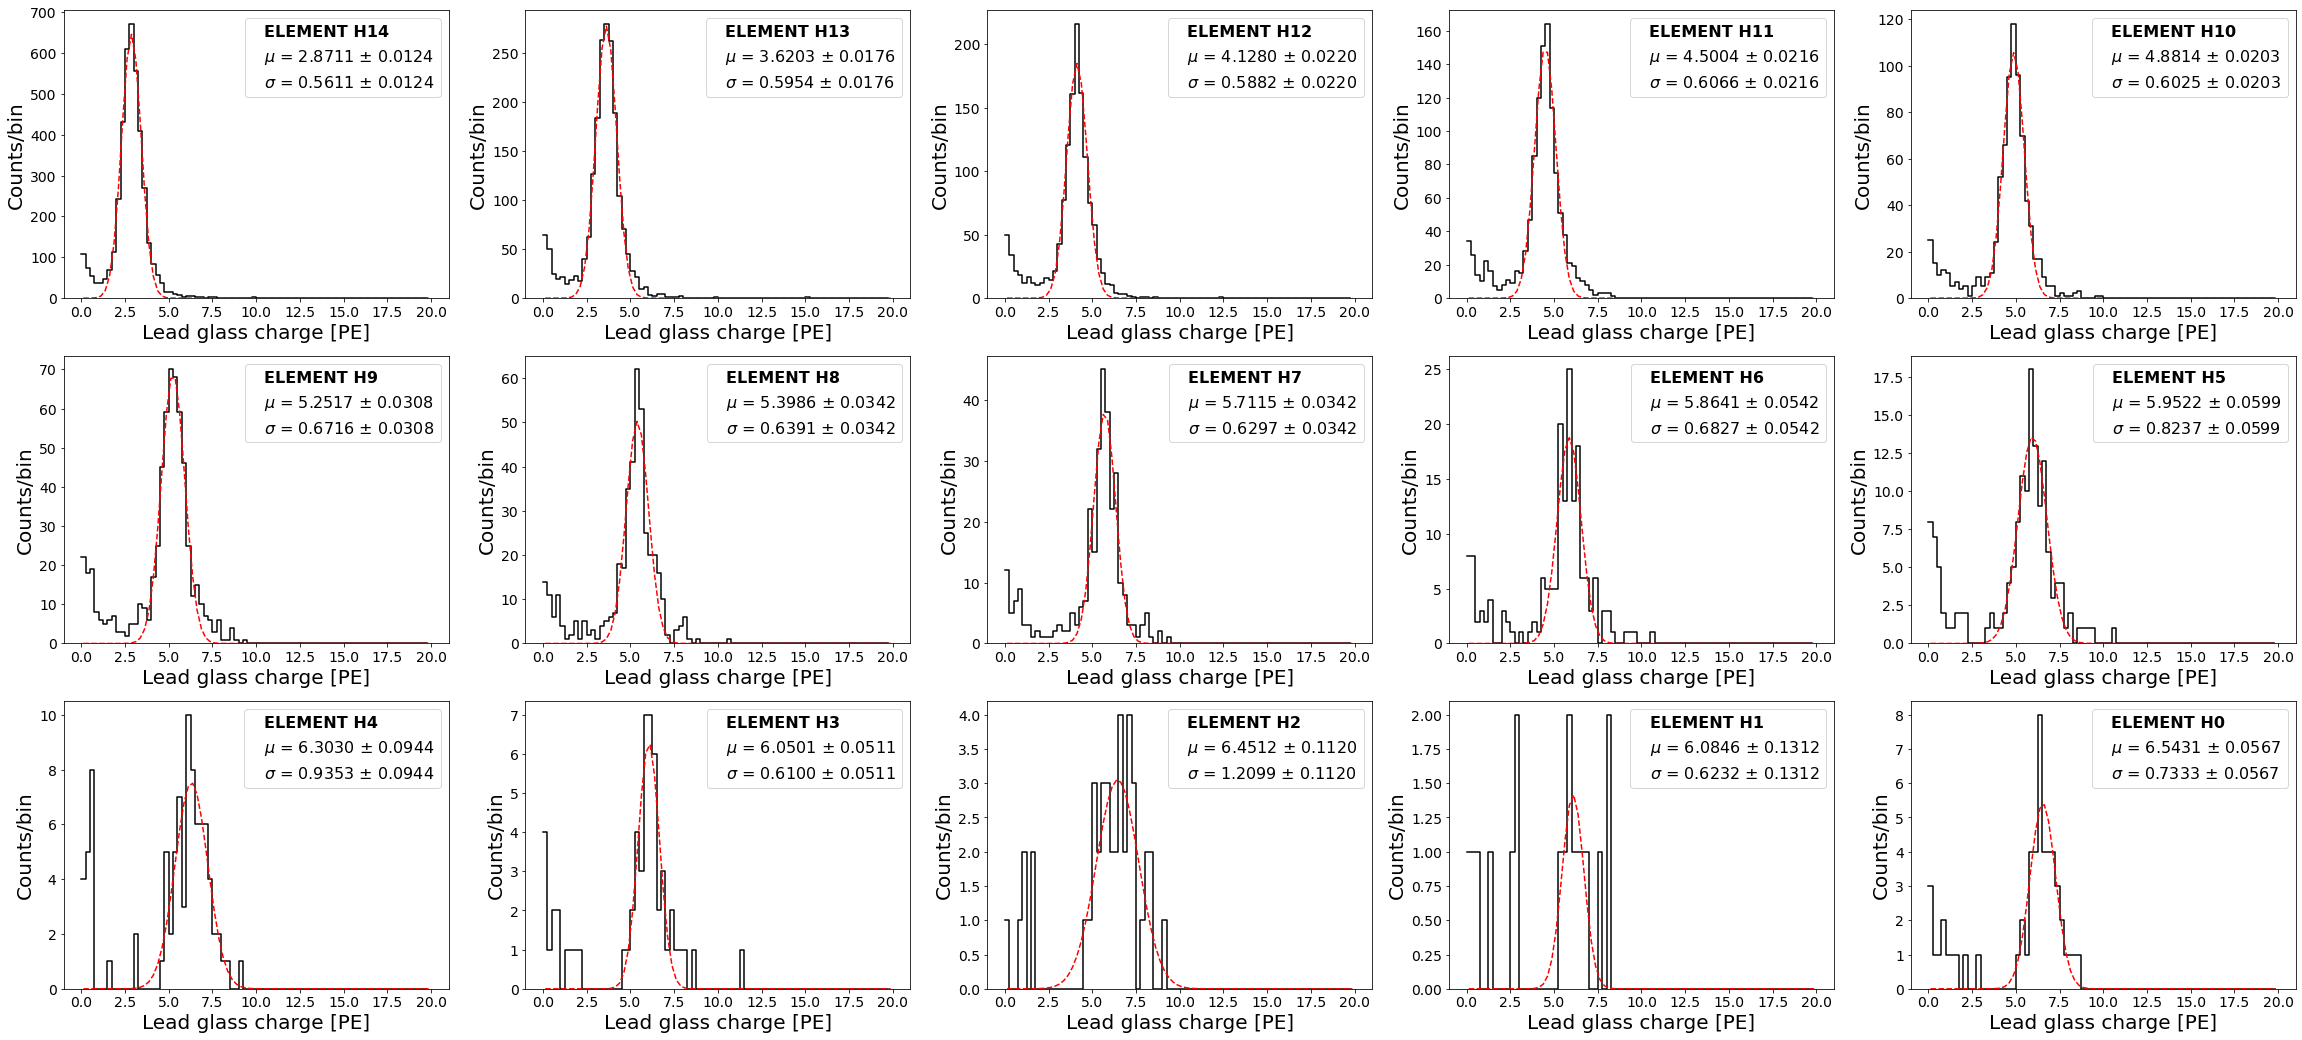

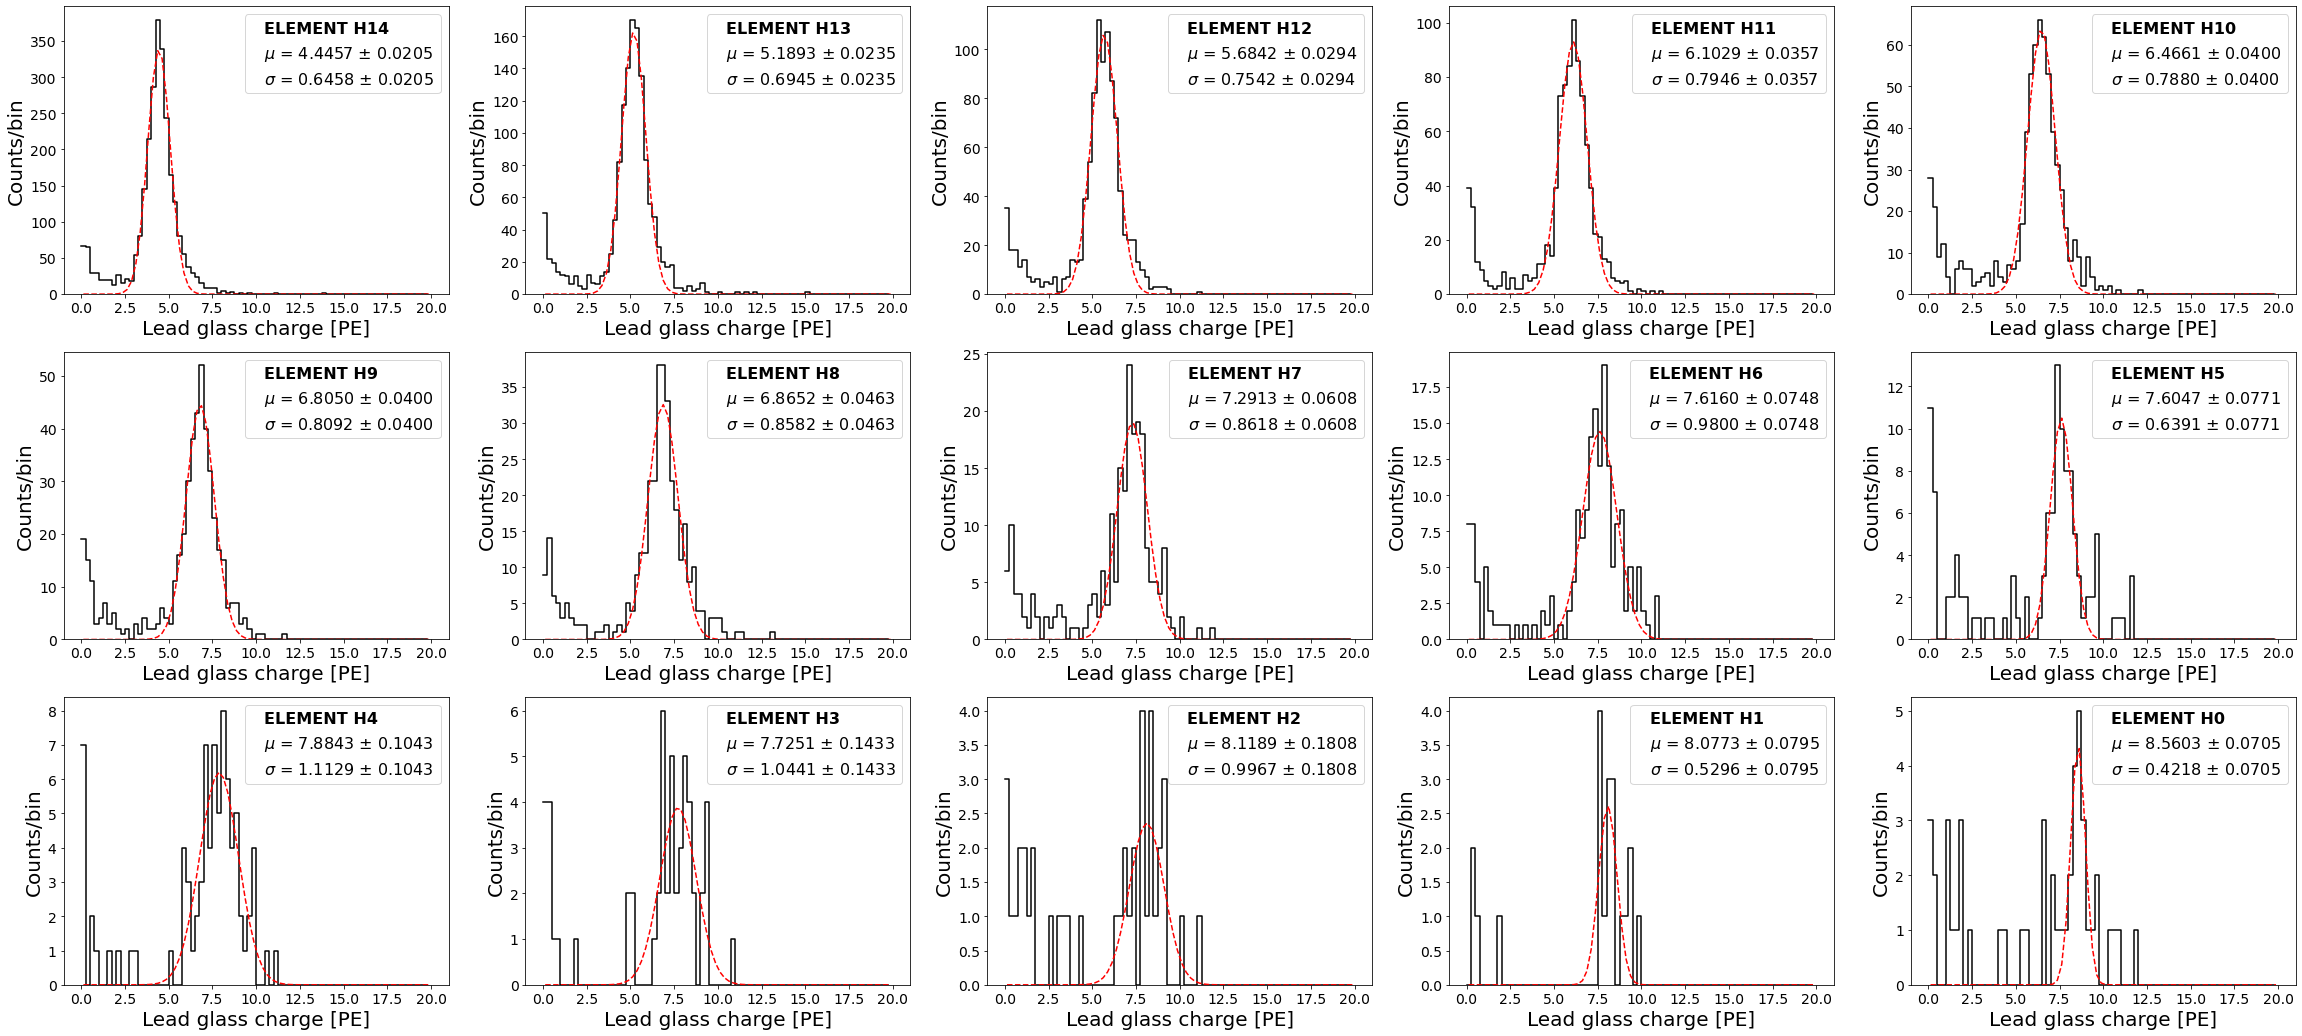

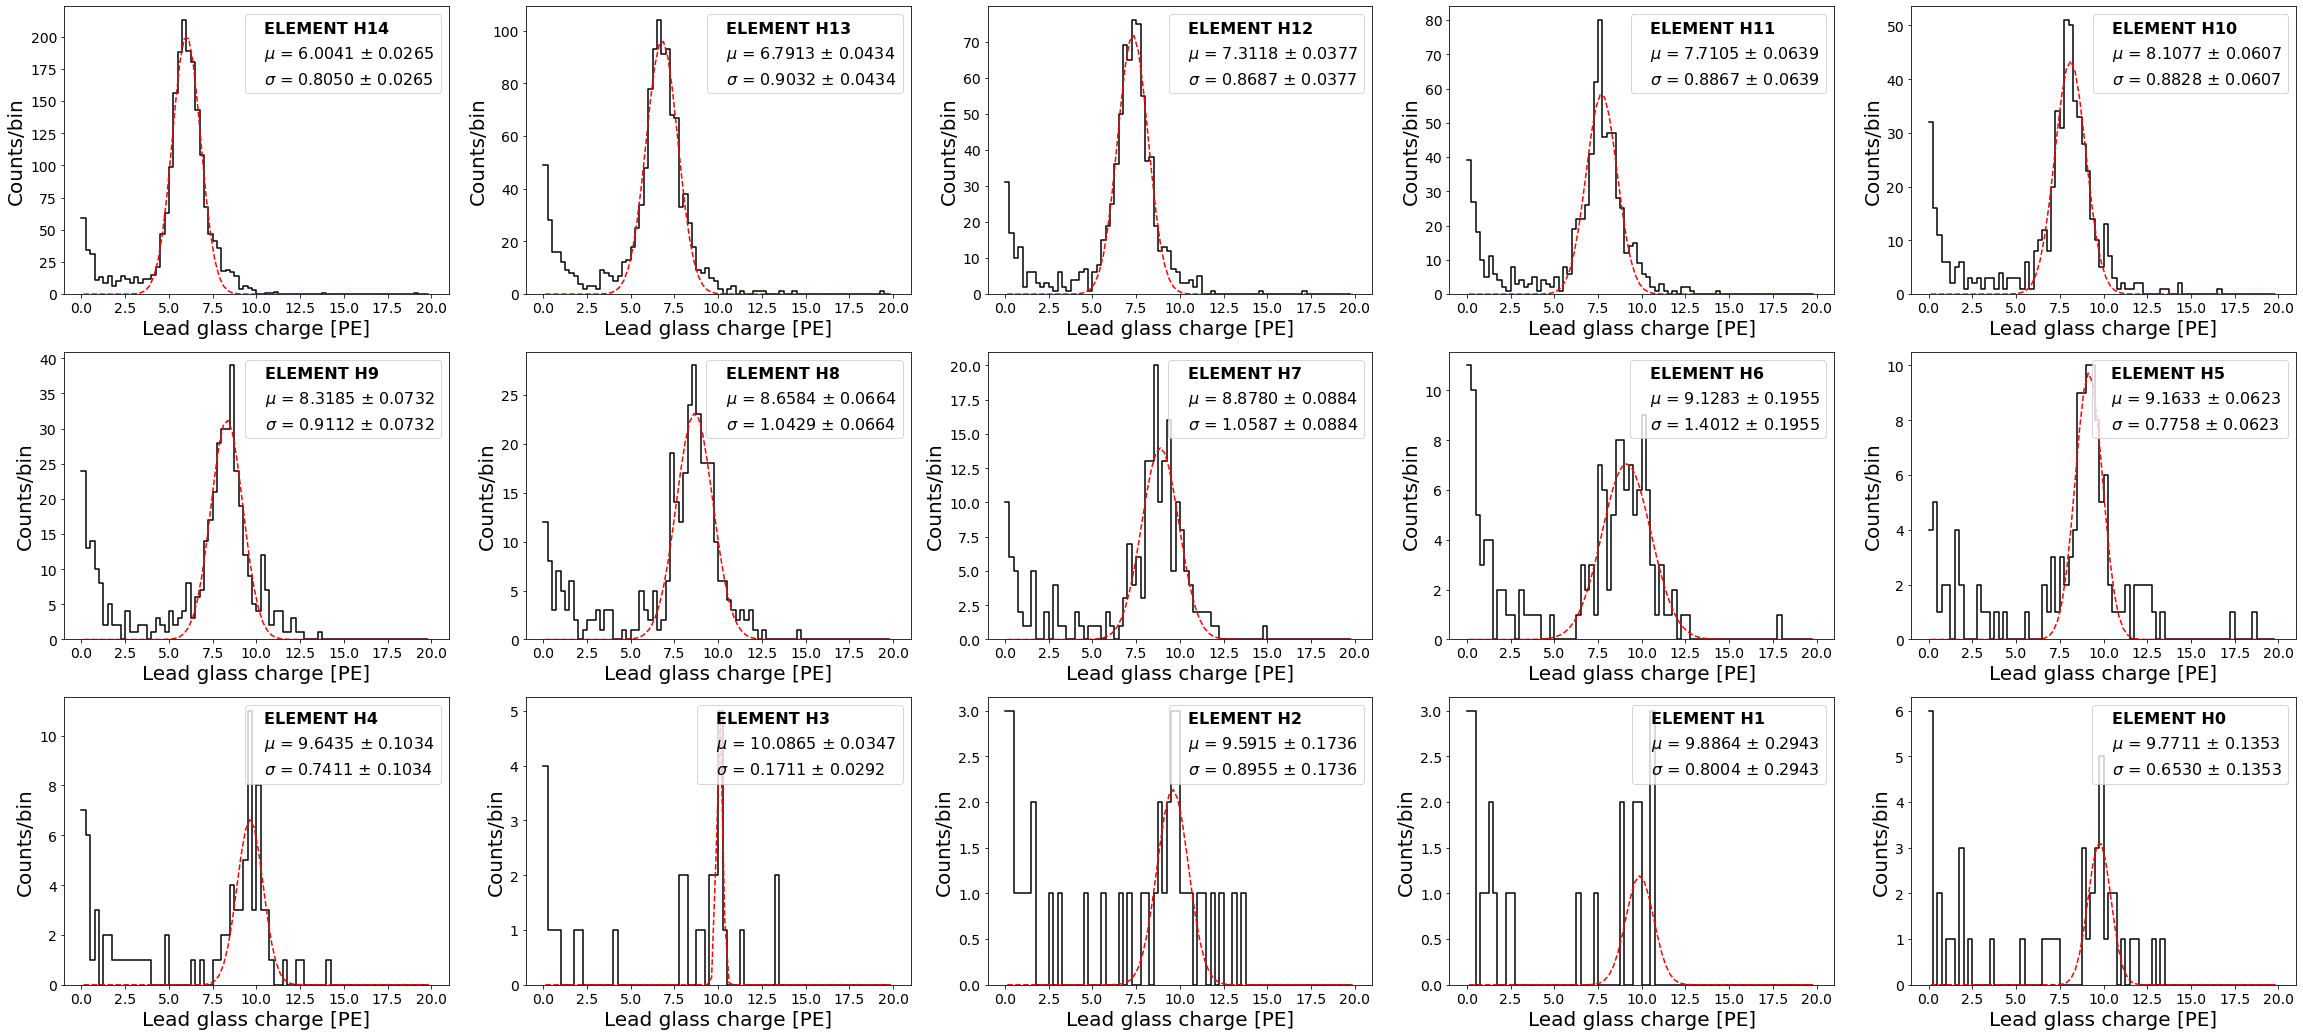

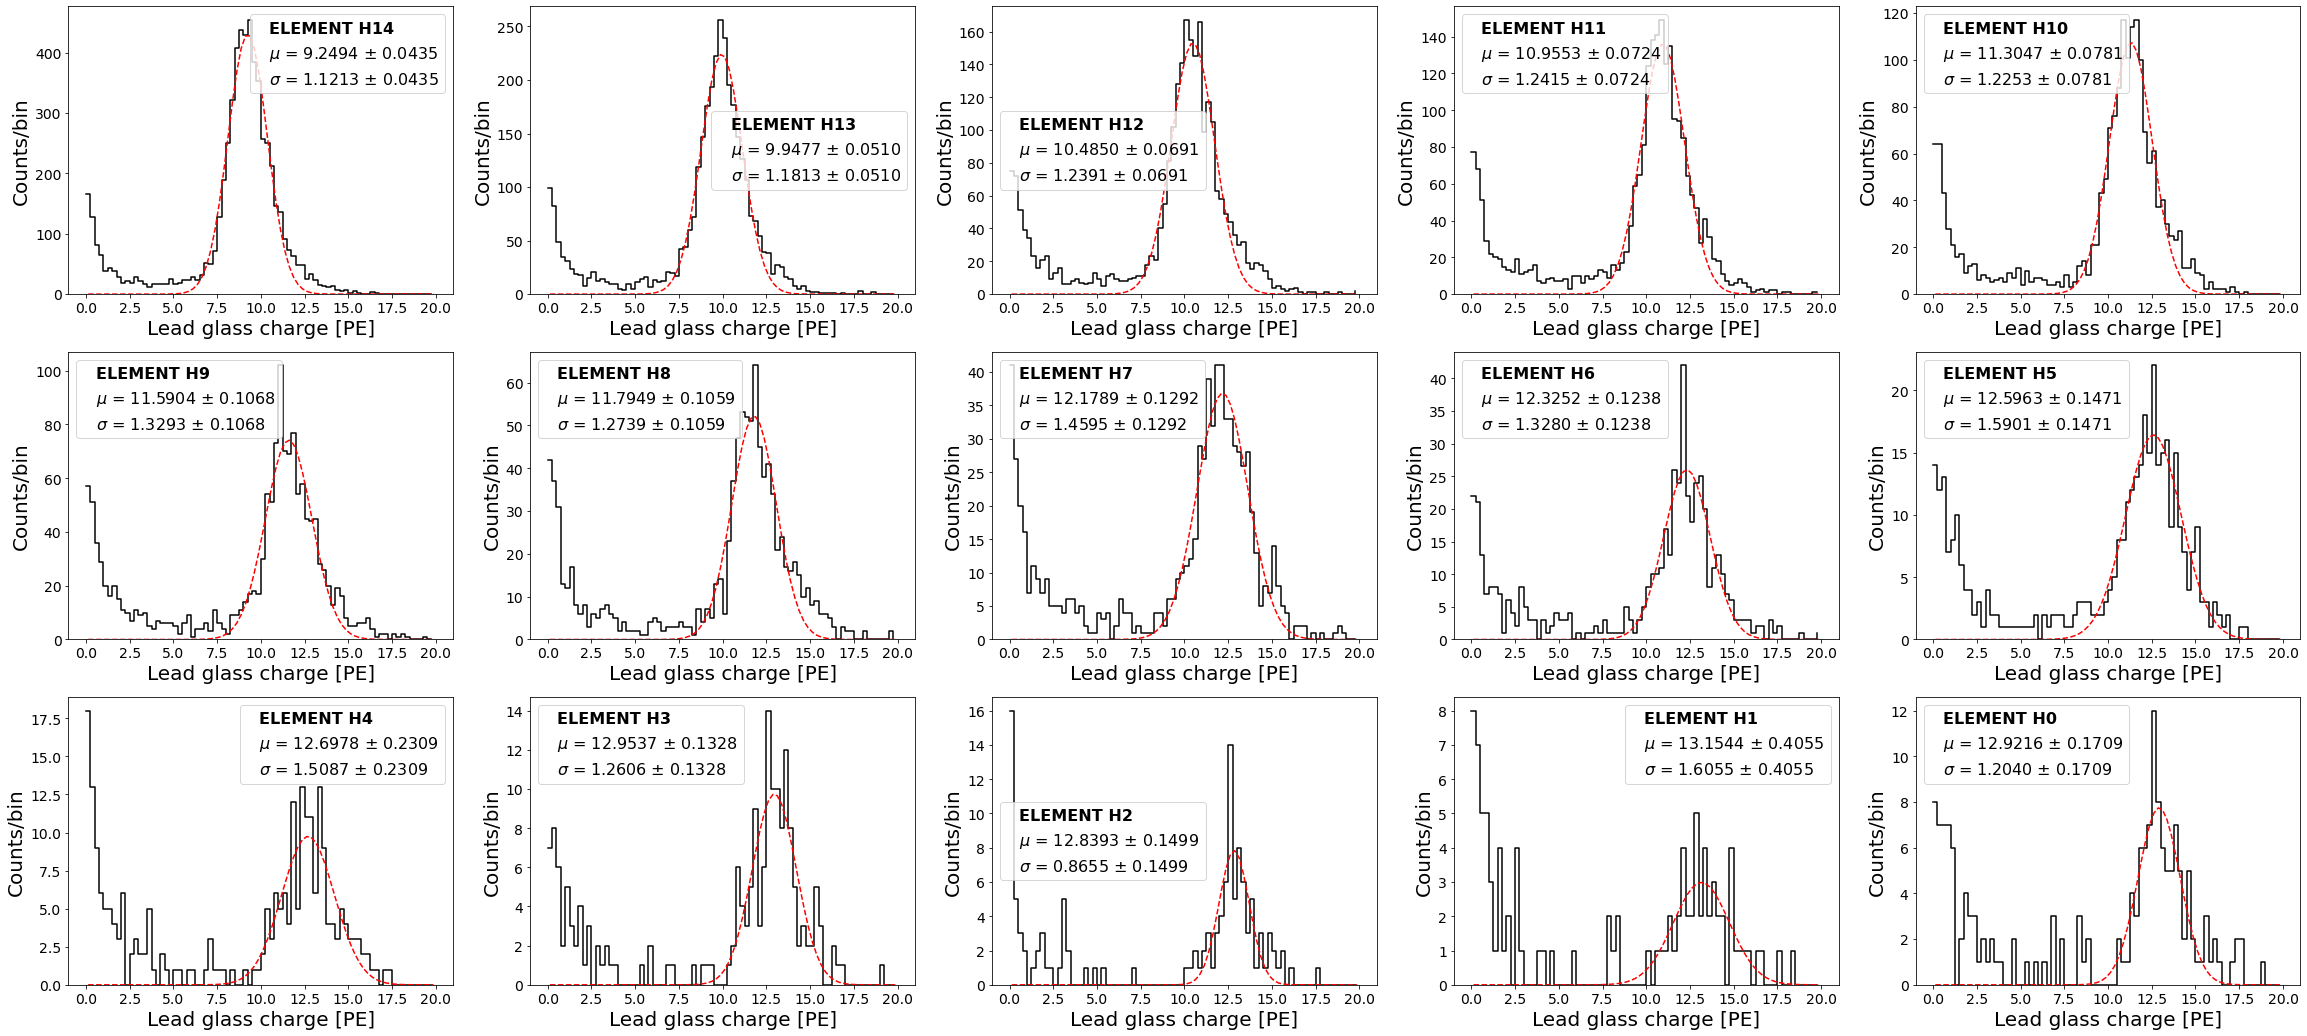

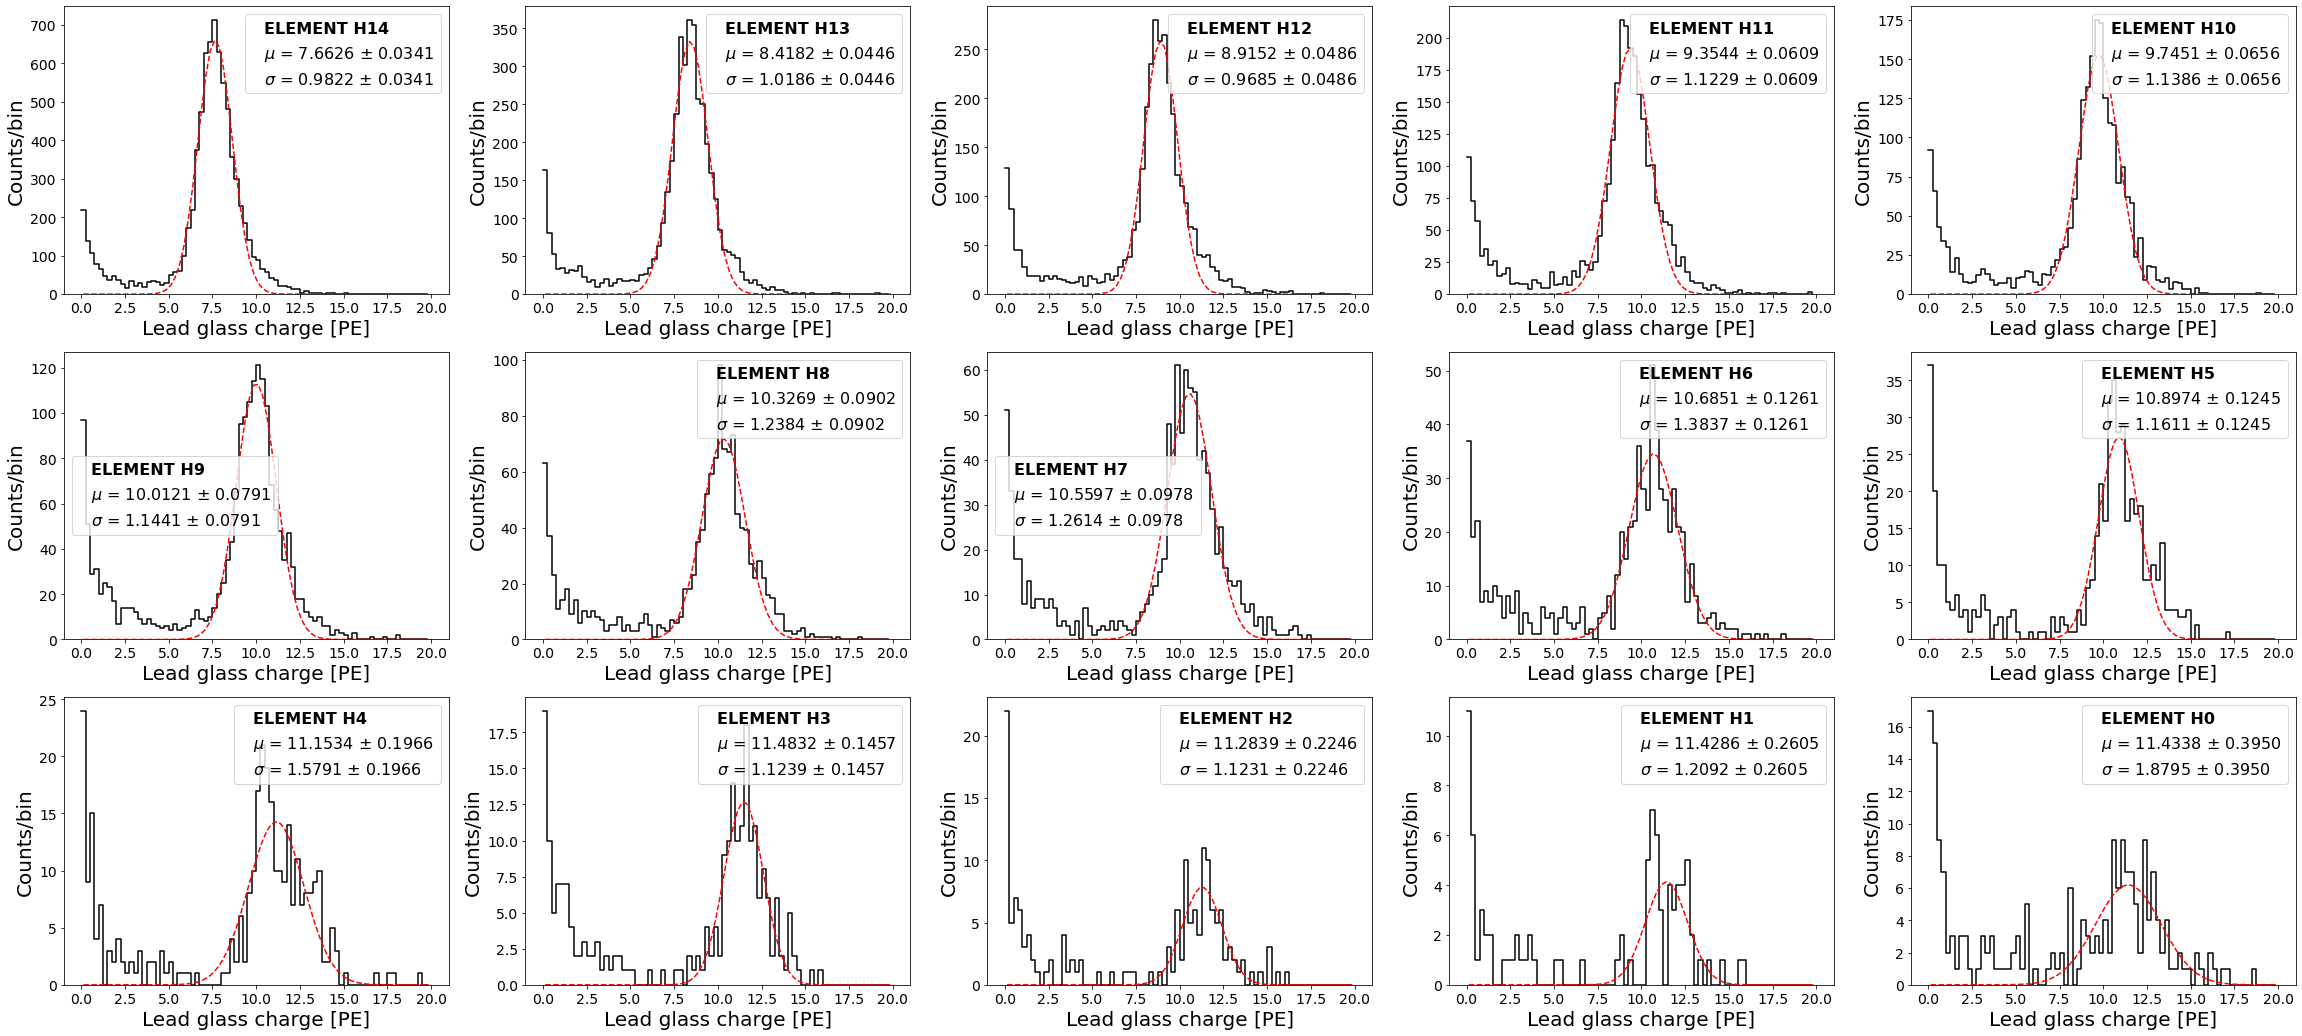

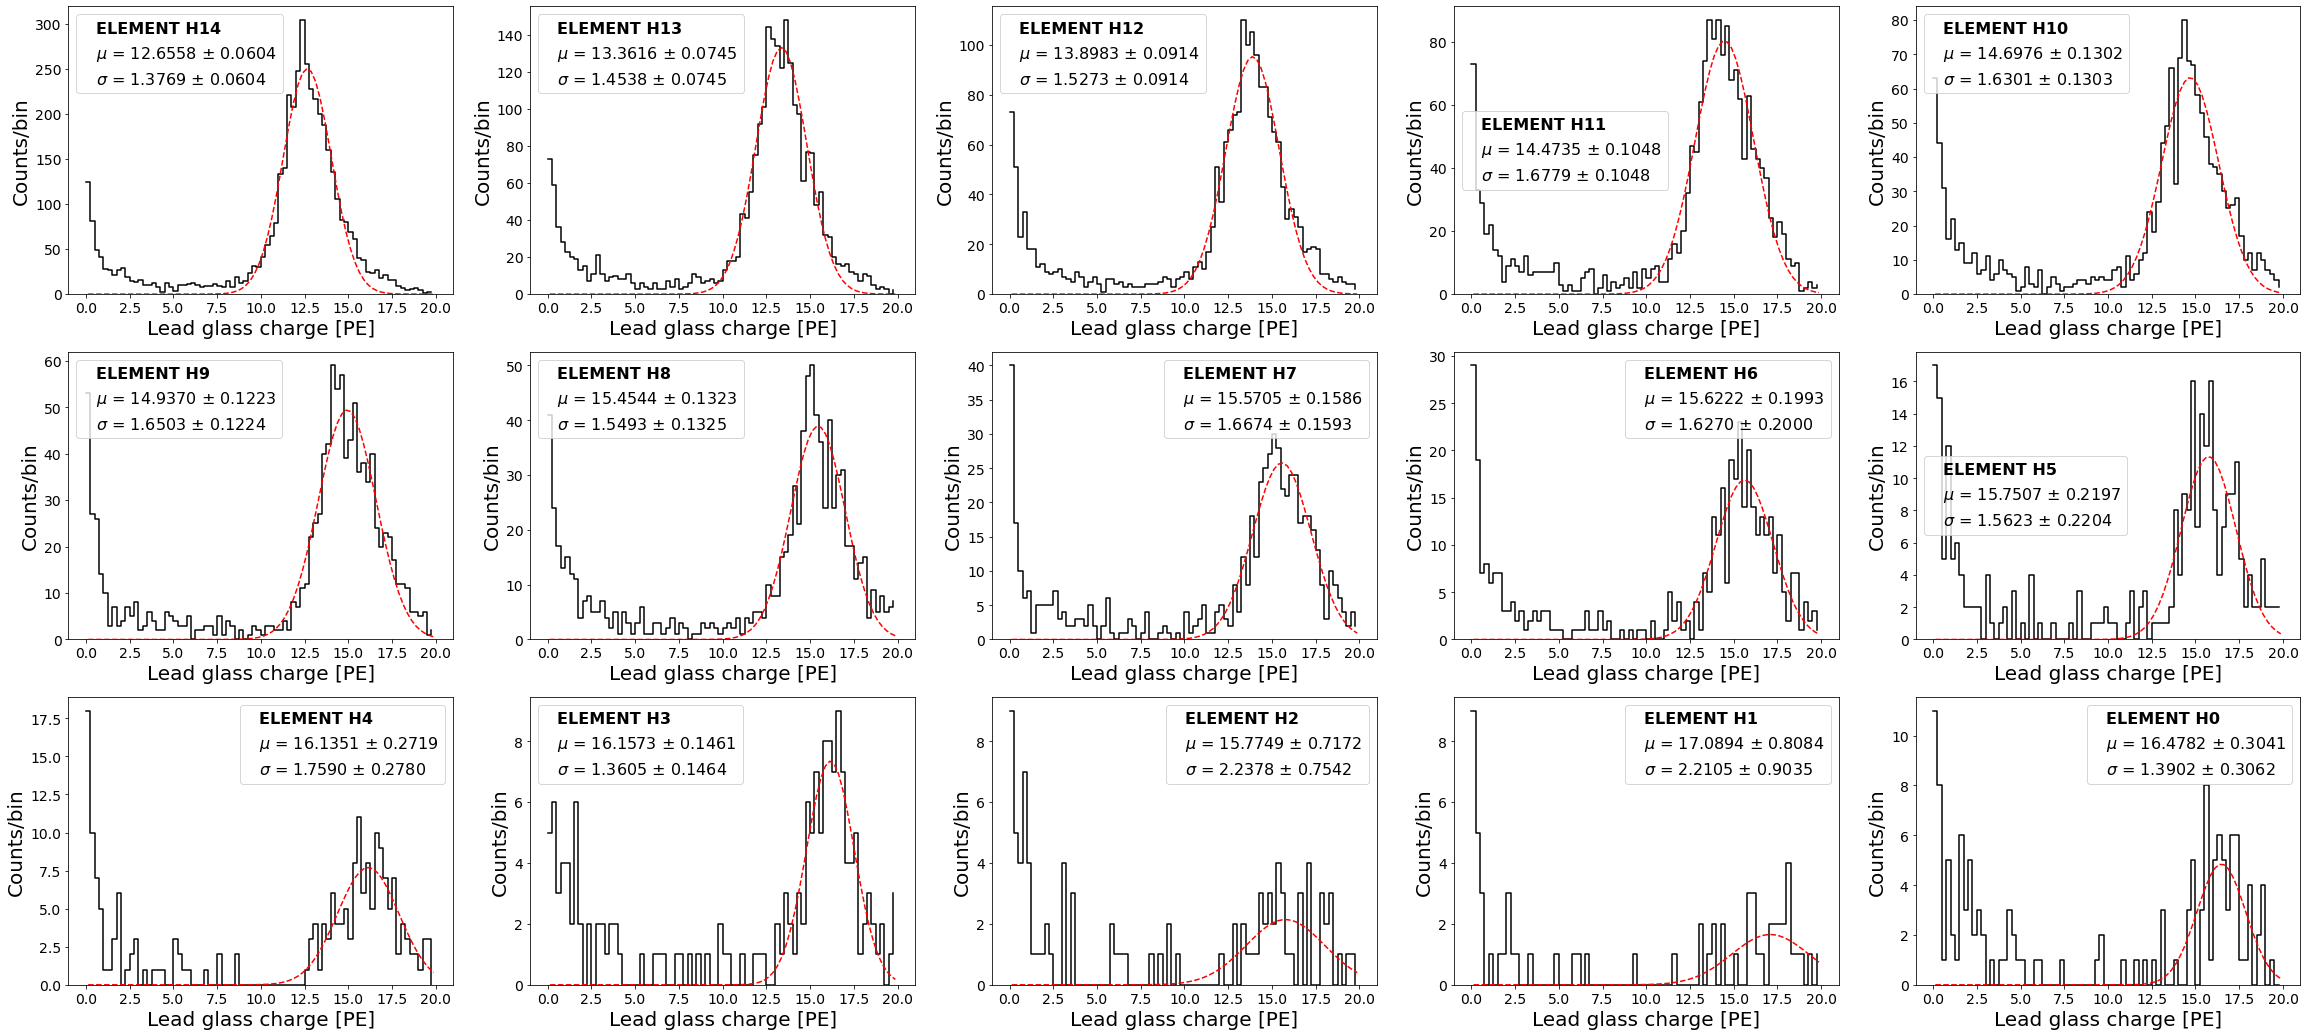

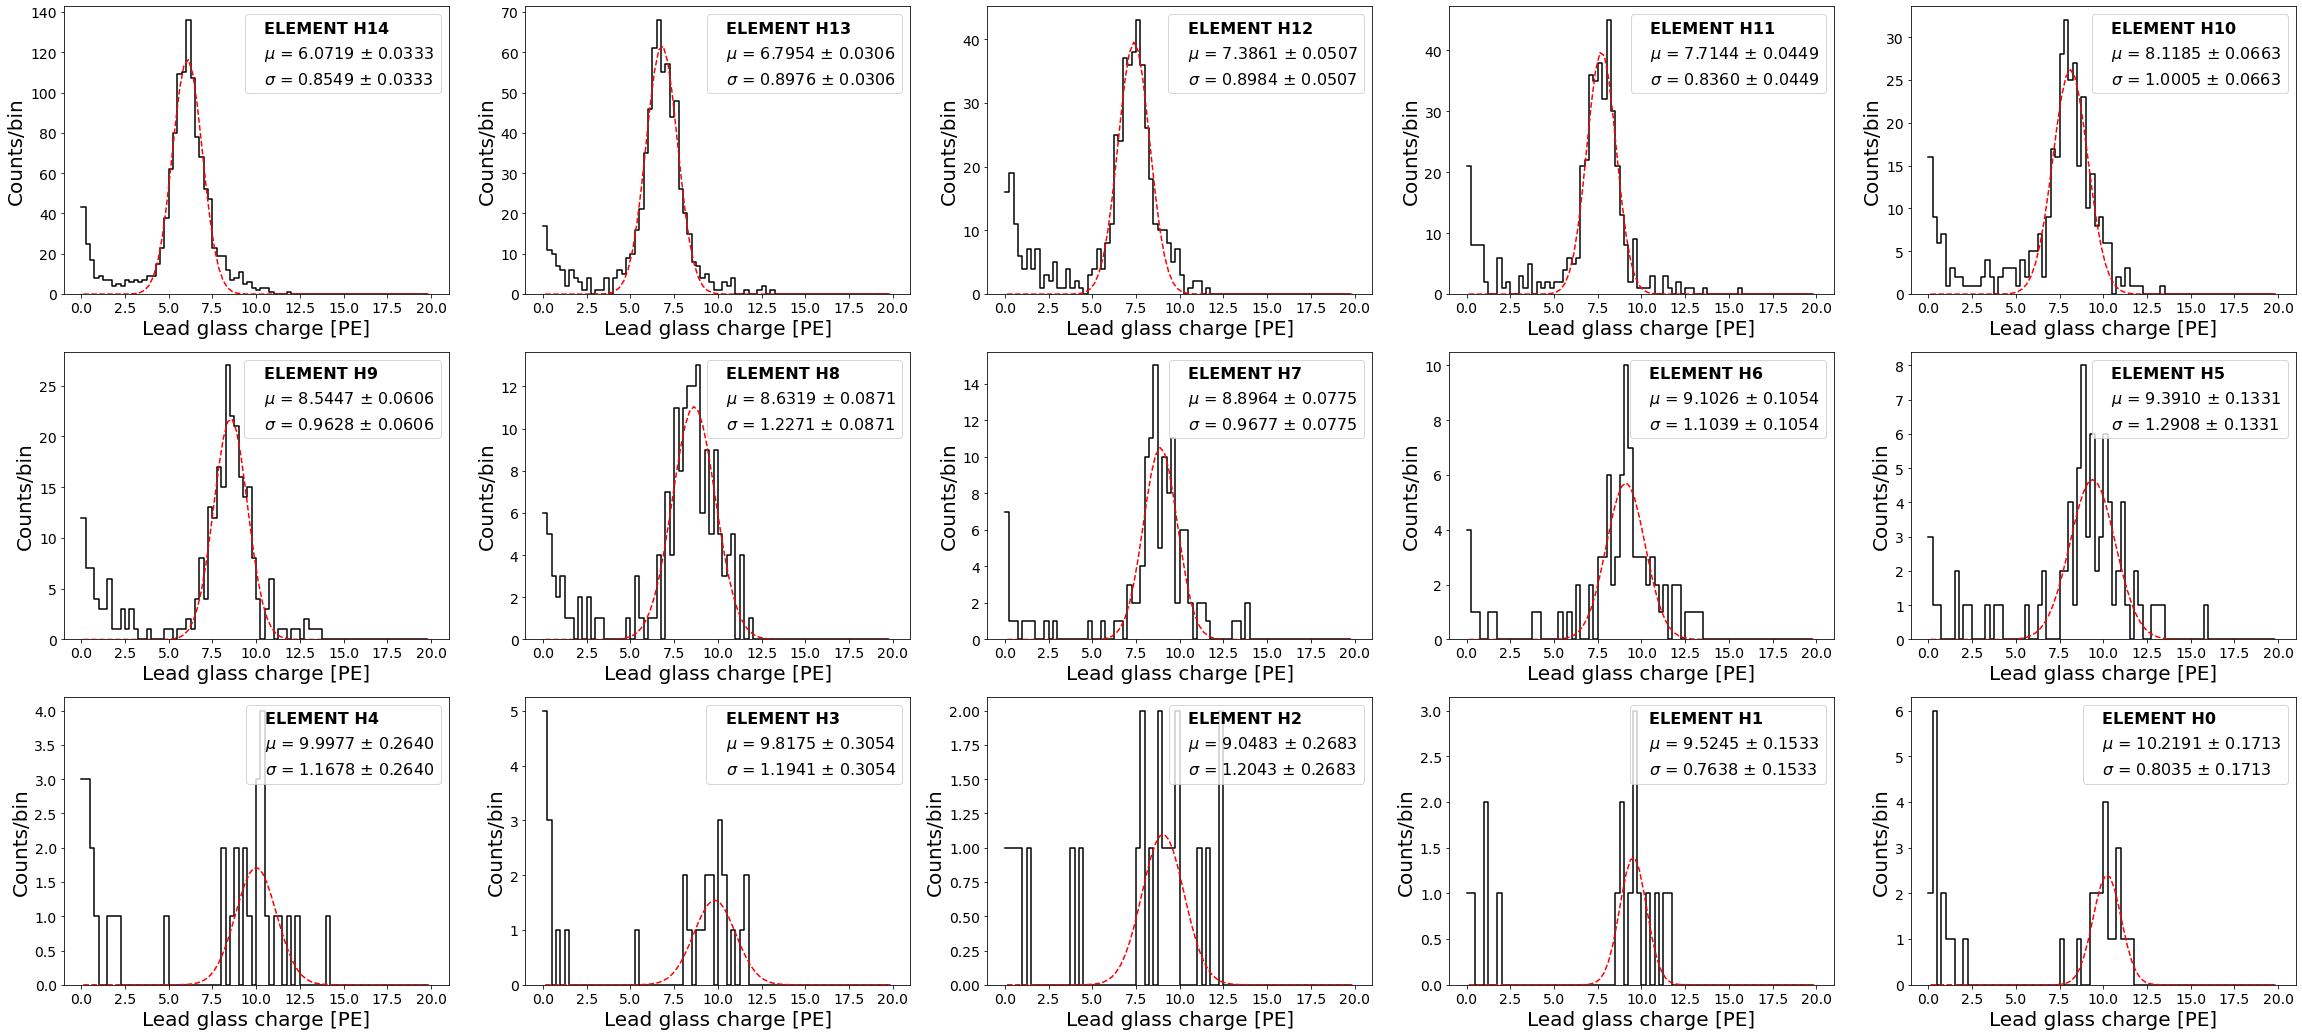

In [29]:
# Run the gamma peak analysis for all runs.
all_fit_results, all_fit_arrays = [], []
all_ntot_evts, all_ntot_spills, all_ntot_tagged_evts = [], [], []
for rnum, pbeam in zip(runs, rmomenta):
    
    print("Processing run",rnum,"...")
    df_dict = hd.read_dataframes_from_csv("/Users/jrenner/local/jerenner/T9BeamTestAna/ntuple_dataframes/run000{}".format(rnum))
    
    # Run the timing analysis (event selection).
    final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.charge_analysis_corrected_winInt(df_dict, chg_cuts_wide)
    
    # Save the results of the gamma peak fits for plotting later.
    fit_results, fit_arrays = hd.gamma_peak_plots(final_df, rnum, pbeam, base_dir='plt/gamma_peaks', nbins=80, range=[0,20])
    
    all_fit_results.append(fit_results)
    all_fit_arrays.append(fit_arrays)
    all_ntot_evts.append(ntot_evts)
    all_ntot_spills.append(ntot_spills)
    all_ntot_tagged_evts.append(ntot_tagged_evts)
    
all_fit_results = np.array(all_fit_results)
all_fit_arrays = np.array(all_fit_arrays)

In [31]:
print(len(final_df[final_df.total_hits_HD == 1]))
print(ntot_tagged_evts)

4516
4516


#### Summary of data (*tbl.data*)

In [32]:
# Print table of results.
for rnum,p,nevts,nspills in zip(runs, rmomenta, all_ntot_evts, all_ntot_spills):
    print(f"{rnum} & {p} & {nevts} & {nspills} & \\\\")

731 & 460 & 41260 & 82 & \\
732 & 500 & 25086 & 75 & \\
733 & 600 & 20496 & 77 & \\
734 & 700 & 25592 & 116 & \\
735 & 800 & 24950 & 108 & \\
736 & 900 & 39279 & 163 & \\
737 & 1000 & 33024 & 152 & \\
738 & 1200 & 29866 & 155 & \\
753 & 500 & 18905 & 76 & \\
754 & 600 & 16851 & 79 & \\
755 & 700 & 12490 & 64 & \\
756 & 800 & 9872 & 55 & \\
760 & 1000 & 32529 & 168 & \\
763 & 900 & 41260 & 184 & \\
764 & 1200 & 25276 & 116 & \\
765 & 800 & 5930 & 21 & \\


In [33]:
print("Percentage of events tagged:")
print(all_ntot_tagged_evts/np.array(all_ntot_evts))

Percentage of events tagged:
[0.83230732 0.82245077 0.79991218 0.779814   0.76340681 0.74627664
 0.73619186 0.70317418 0.82025919 0.79105098 0.76541233 0.75688817
 0.73392972 0.73051381 0.70121855 0.76155143]


#### Plot the number of tagged events per spill

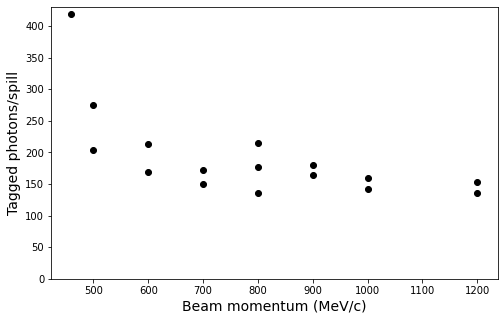

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

all_ntot_spills = np.array(all_ntot_spills)
all_ntot_tagged_evts = np.array(all_ntot_tagged_evts)

ax.plot(rmomenta,all_ntot_tagged_evts/all_ntot_spills,'o',color='black')
ax.set_ylim([0,430])
ax.set_xlabel("Beam momentum (MeV/c)",fontsize=14)
ax.set_ylabel("Tagged photons/spill",fontsize=14)
plt.savefig("tagged_evts_per_spill.pdf",bbox_inches='tight')

#### Lead glass calibration plot (*fig.LG_calibration*)

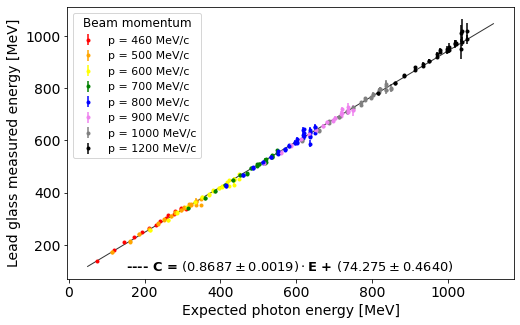

In [52]:
# Plot all gamma peak means and fit lines on the same plot.
elec_hit_momenta_values = [v for v in hd.elec_hit_momenta_calc.values()]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
momentum_color = {460: "red", 500: "orange", 600: "yellow", 700: "green", 
                  800: "blue", 900: "violet", 1000: "gray", 1100: "brown", 1200: "black"}
momentum_plt   = {460: False, 500: False, 600: False, 700: False,
                  800: False, 900: False, 1000: False, 1100: False, 1200: False}

all_e_gamma_expected = []
for run_momentum, fit_array in zip(rmomenta,all_fit_arrays):
    
    # Get the fit means and errors for this run.
    fit_means, fit_smeans = fit_array[0], fit_array[1]
    
    # Apply the electron-based calibration
    fit_energy = [(mu - ecal_b)/ecal_m for mu in fit_means]
    fit_esigmas = [mu_e/ecal_m for mu_e in fit_smeans]

    # Compute the expected energies for each gamma.
    e_gamma_expected = [run_momentum - mval*1000 for mval in elec_hit_momenta_values[::-1]]
    all_e_gamma_expected.append(e_gamma_expected)
    
    if(not momentum_plt[run_momentum]):
        ax.errorbar(e_gamma_expected, fit_energy, yerr=fit_esigmas, fmt='.', 
                    color=momentum_color[run_momentum], label=f"p = {run_momentum} MeV/c")
        momentum_plt[run_momentum] = True
    else:
        ax.errorbar(e_gamma_expected, fit_energy, yerr=fit_esigmas, fmt='.', 
                    color=momentum_color[run_momentum])
        
# Fit a line to all results at once.
all_fit_means = (all_fit_arrays[:,0,:].flatten() - ecal_b)/ecal_m
all_fit_smeans = all_fit_arrays[:,1,:].flatten()/ecal_m
all_e_gamma_expected = np.array(all_e_gamma_expected).flatten()

p0 = [(np.max(all_e_gamma_expected) - np.min(all_e_gamma_expected))/(np.max(all_fit_means) - np.min(all_fit_means)),all_e_gamma_expected[0]]
popt, pcov = curve_fit(hd.line, all_e_gamma_expected, all_fit_means, p0, sigma=all_fit_smeans)
x = np.linspace(50, 1120, 1000)
y = hd.line(x, *popt)
perr = np.sqrt(np.diag(pcov))
#ax.plot(x, y, label='C = $({:.2f} \pm {:.2f}) x 10^{{-4}} \cdot $p + $({:.3f} \pm {:.4f})$'.format(popt[0]*10000,perr[0]*10000,popt[1],perr[1]), color='red', alpha=0.8, linewidth=3, linestyle=':')
ax.plot(x, y, color='black', alpha=0.8, linewidth=1, linestyle='-')
#ax.annotate("---- C = $({:.4f} \pm {:.4f}) x 10^{{-2}} \cdot $E + $({:.3f} \pm {:.4f})$".format(popt[0]*100,perr[0]*100,popt[1],perr[1]), xy=(500, 0.10), xytext=(200, 0.01), fontsize=13, fontweight='bold', color='black')
ax.annotate("---- C = $({:.4f} \pm {:.4f}) \cdot $E + $({:.3f} \pm {:.4f})$".format(popt[0],perr[0],popt[1],perr[1]), xy=(500, 100), xytext=(150, 100), fontsize=13, fontweight='bold', color='black')

ax.legend(title="Beam momentum",title_fontsize=12,fontsize=11)
ax.set_ylabel('Lead glass measured energy [MeV]',fontsize=14)
ax.set_xlabel('Expected photon energy [MeV]',fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.savefig("LG_calibration.pdf", bbox_inches='tight')

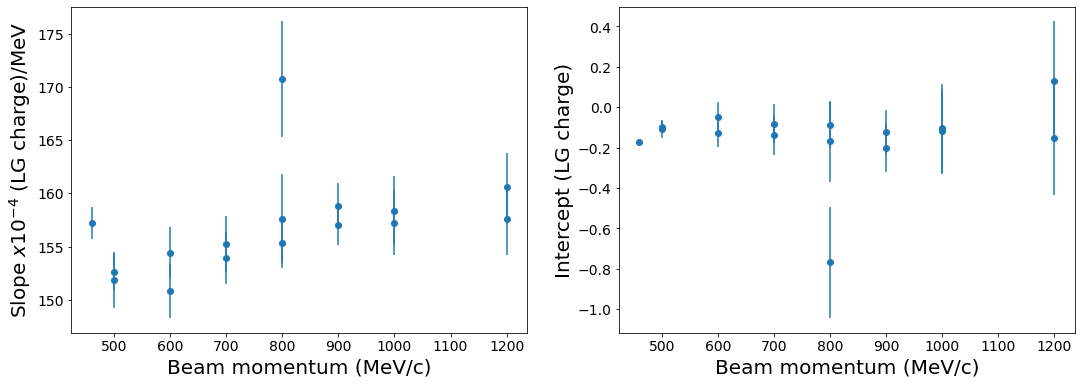

In [53]:
# Plot the slope and intercept of each calibration curve vs. momentum.
mvals = all_fit_results[:,0]
merr = all_fit_results[:,1]
bvals = all_fit_results[:,2]
berr = all_fit_results[:,3]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
flat_axes = axes.ravel()

flat_axes[0].errorbar(rmomenta,mvals*10000,yerr=merr*10000,fmt='o')
flat_axes[0].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[0].set_ylabel('Slope $x 10^{-4}$ (LG charge)/MeV',fontsize=20)
flat_axes[0].tick_params(axis="x", labelsize=14)
flat_axes[0].tick_params(axis="y", labelsize=14)

flat_axes[1].errorbar(rmomenta,bvals,yerr=berr,fmt='o')
flat_axes[1].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[1].set_ylabel('Intercept (LG charge)',fontsize=20)
flat_axes[1].tick_params(axis="x", labelsize=14)
flat_axes[1].tick_params(axis="y", labelsize=14)

## 3b. Single-run analysis

In [54]:
# Define a Gaussian function with amplitude, mean, and standard deviation.
def gauss(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

# Reload charge cuts if necessary for debugging.
def reload_constants():
    import importlib
    importlib.reload(hodoscope_constants_win)
    global chg_cuts_tight, chg_cuts_wide, chg_ranges_wide
    chg_cuts_tight = hodoscope_constants_win.chg_cuts_tight
    chg_cuts_wide = hodoscope_constants_win.chg_cuts_wide
    chg_ranges_wide = hodoscope_constants_win.chg_ranges_wide

In [55]:
# Read in all dataframes from a given run
rnum = 735
low_radiation = False
pbeam = 800
tail_threshold = 2.6
df_dict = hd.read_dataframes_from_csv(f"{ntuple_pd_dir}/run000{rnum}")
df_dict.keys()

dict_keys(['EventInfo', 'ACT0L', 'ACT1L', 'ACT3R', 'TOF01', 'HD3', 'HD11', 'HD10', 'HD2', 'TOF00', 'HD0', 'TOF02', 'HD12', 'HD13', 'TOF03', 'HD1', 'TOF13', 'HD5', 'PbGlass', 'TOF12', 'HD4', 'HD6', 'TOF10', 'HD14', 'HD7', 'TOF11', 'HD9', 'HD8', 'TriggerScint', 'ACT0R', 'ACT1R', 'ACT3L'])

Examine the charge for each detector. Here we will be placing "wide cuts" which encompass the entire range of sensible charge values for each detector.

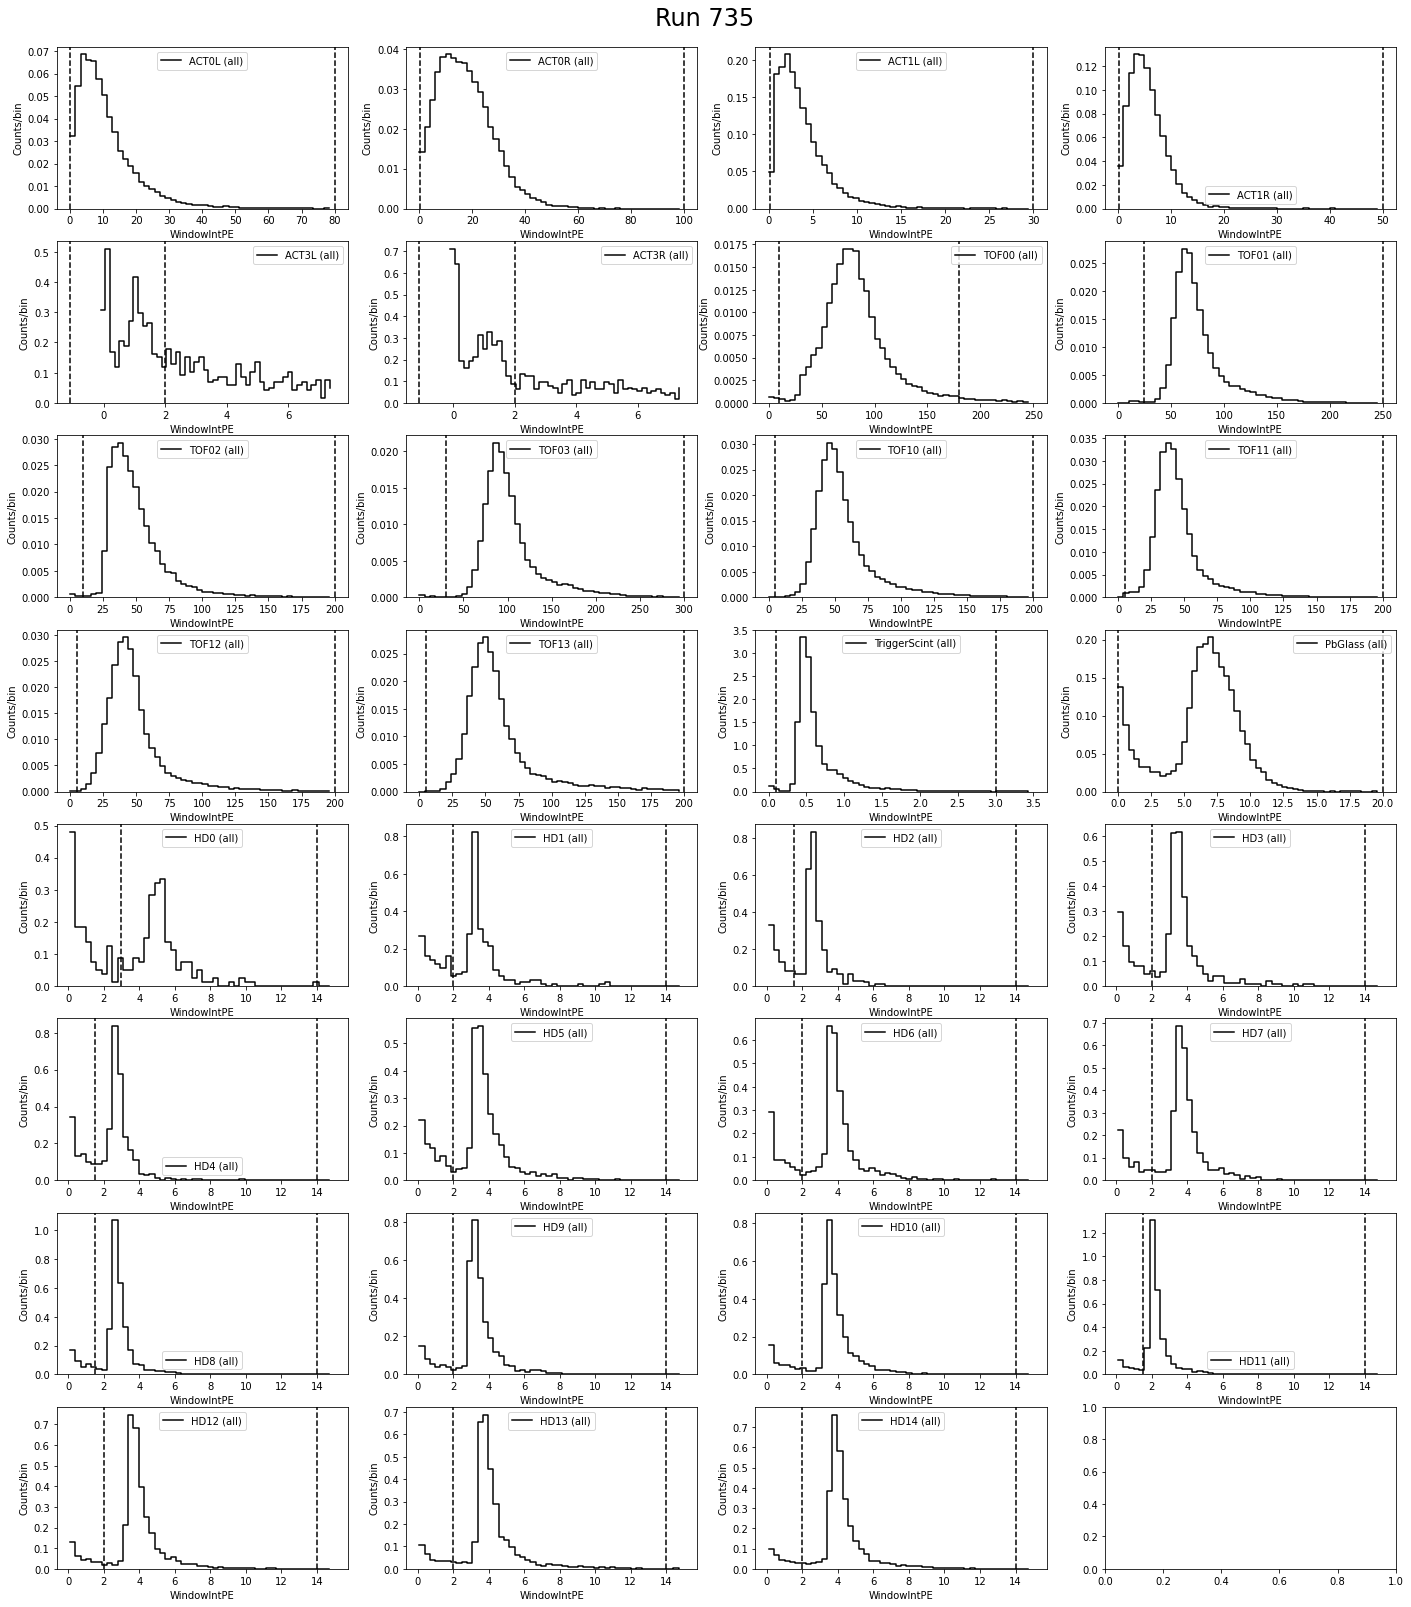

In [56]:
# Reload charge cuts if necessary.
reload_constants()

# Assign the charge cuts
chg_cuts = chg_cuts_wide
chg_range = chg_ranges_wide

hd.plot_charge_histograms(df_dict, 'WindowIntPE', chg_cuts, chg_range, rnum, nbins = 50, evt_list = None, lbl = 'all', evt_list_2 = None, lbl_2 = 'all', select_nonzero_peaks = True, normed = True, logscale = False)

##### Apply the charge cuts
Here we create a dataframe `final_df` containing the events that passed the wide charge cuts. The function `charge_analysis_corrected_winInt` returns a dataframe containing all lead glass peaks (for events containing 1 peak only) and a `hit_` column for each detector specifying whether the charge cuts were met (= 1) or not (= 0).

In [57]:
final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.charge_analysis_corrected_winInt(df_dict, chg_cuts_wide)

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


#### Gamma peaks plot (*fig.gamma_peaks*)

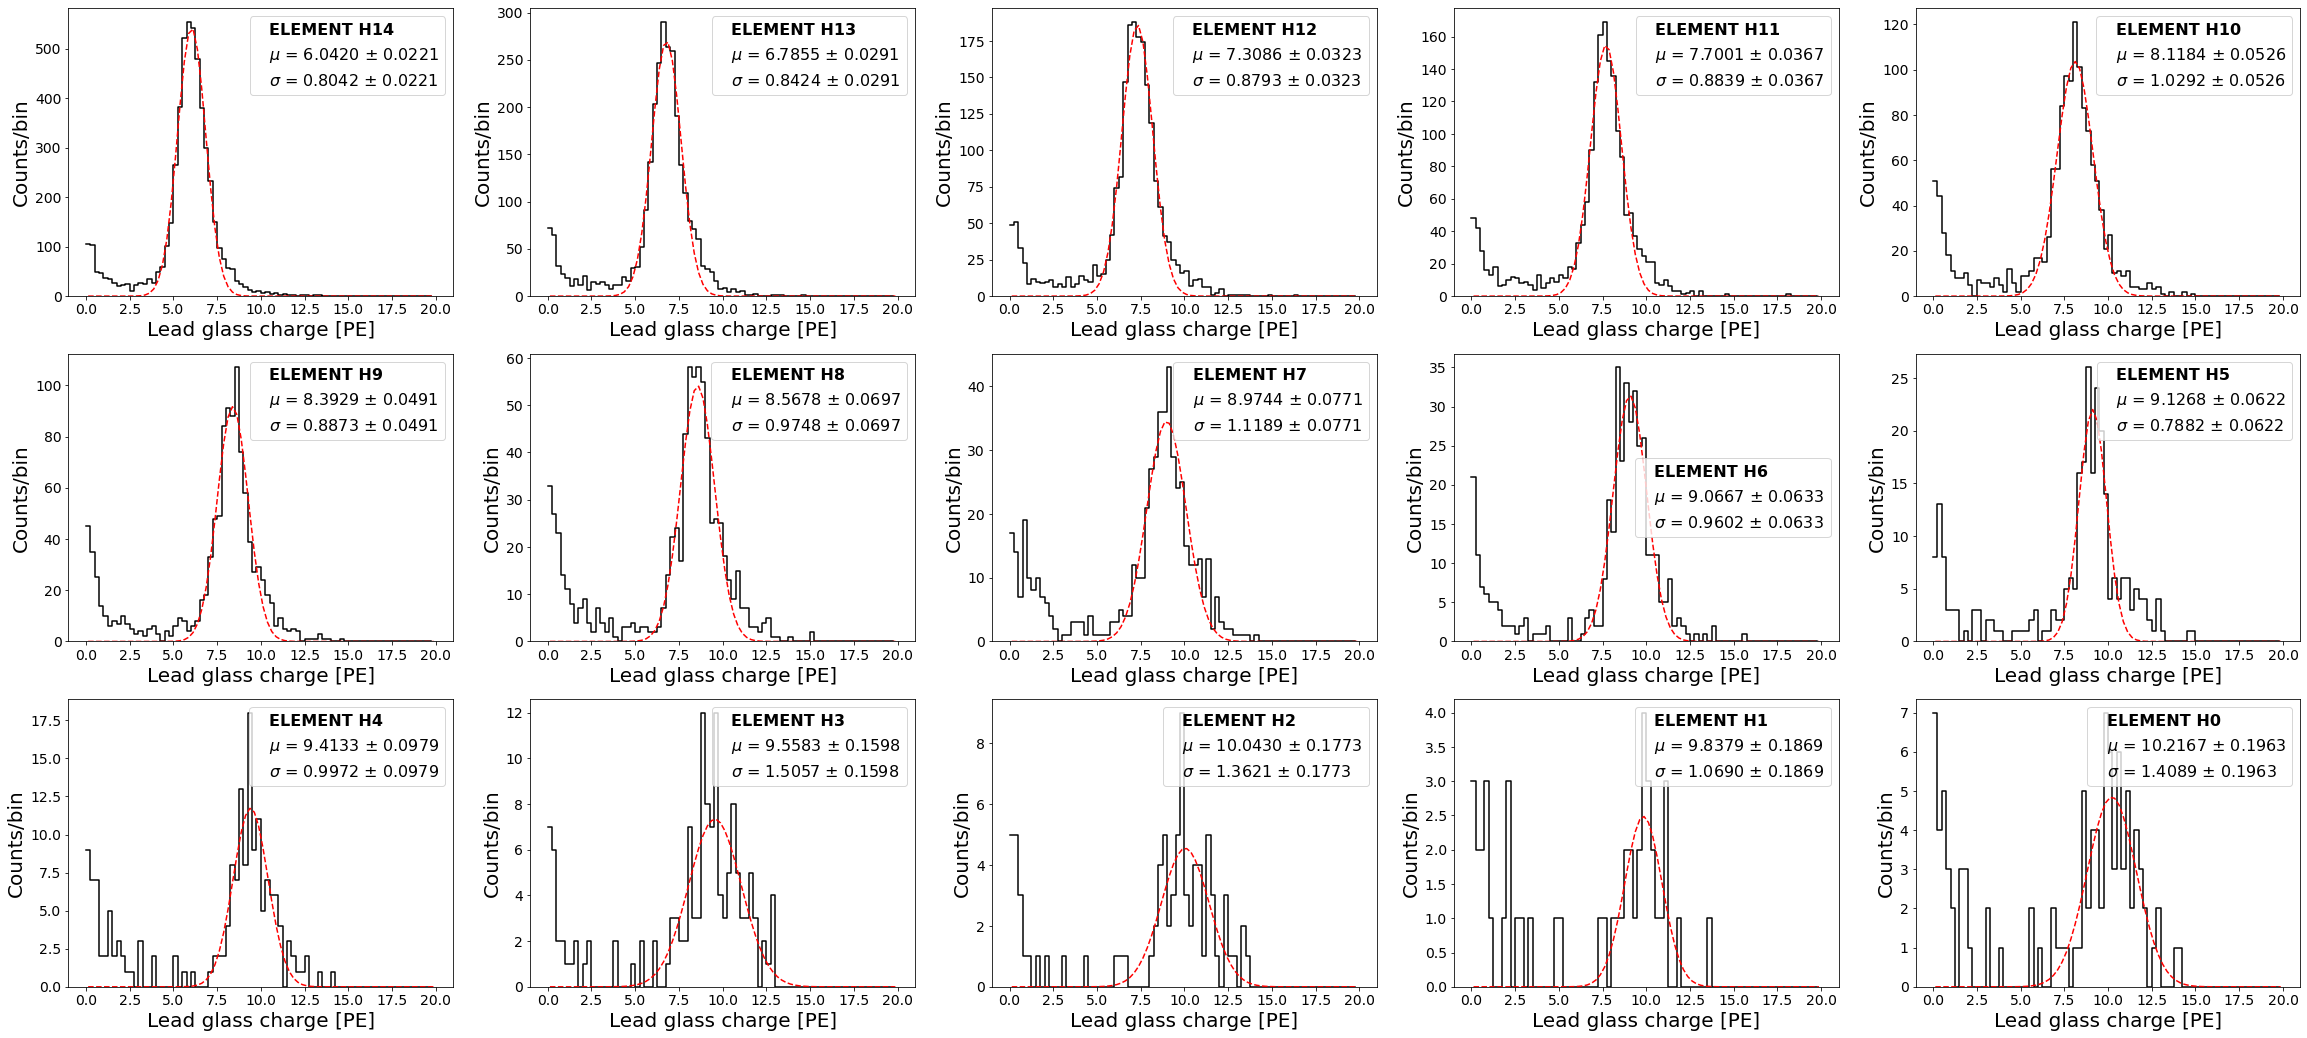

In [58]:
fit_results, fit_arrays = hd.gamma_peak_plots(final_df, rnum, pbeam, base_dir='plt/gamma_peaks', nbins=80, range=[0,20], timing_cuts=False, low_radiation=False)

#### HD14 gamma peak (*fig.gamma_peak_H14*)

In [59]:
def gauss(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

Uncalibrated histogram

Initial params: [536, 5.710829349844119, 1.891183178711305]


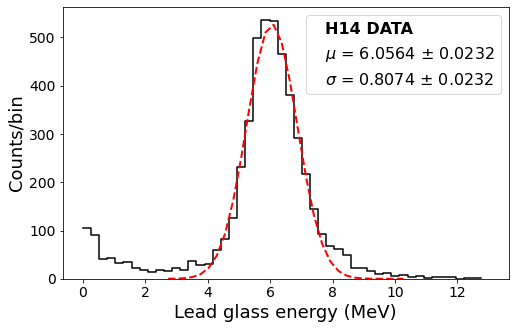

In [60]:
hd.plot_HD14_peak(final_df, e_range = [0, 13], ecal_m = 1.0, ecal_b = 0.0, nbins = 50, fit_start = 10, fit_end = 40, normed = False, energy_cut = 0, low_radiation = False)

Calibrated histogram

Initial params: [529, 408.58352339409026, 101.76163747109932]


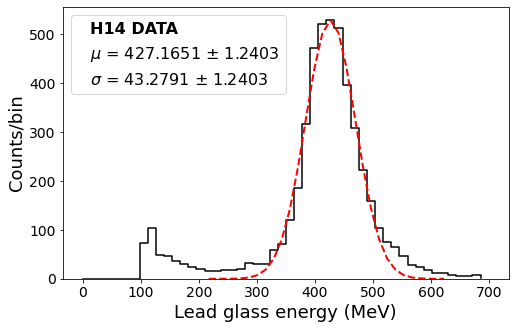

In [61]:
hd.plot_HD14_peak(final_df, e_range = [0, 700], ecal_m = 1.86e-2, ecal_b = -1.89, nbins = 50, fit_start = 15, fit_end = 45, normed = False, energy_cut = 50, low_radiation = False)

### Application of additional charge cuts

In [62]:
df_widecuts, _, _, _ = hd.charge_analysis_corrected_winInt(df_dict, chg_cuts_wide)

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [63]:
# Select HD14 peak and tail events
cuts_hd14      = (df_widecuts.hit_HD14 == 1)
cuts_hd14_peak = cuts_hd14 & (df_widecuts.LG_WindowIntPE >= tail_threshold)
cuts_hd14_tail = cuts_hd14 & (df_widecuts.LG_WindowIntPE <  tail_threshold) # & (final_df.LG_WindowIntPE > 1.0)

# Get the list of peak events.
df_peak = df_widecuts[cuts_hd14_peak]
evt_list_PEAK = np.array(df_peak.event.values)

# Get the list of tail events.
df_tail = df_widecuts[cuts_hd14_tail]
evt_list_TAIL = np.array(df_tail.event.values)

print(f"{len(evt_list_PEAK)} peak events and {len(evt_list_TAIL)} tail events")

4740 peak events and 1060 tail events


Now we remake the charge plots showing the normalized distributions of peak (>= tail_threshold) and tail (< tail_threshold) events.

[ACT0L] before selection 24444
[ACT0L] selecting out 4740 events to get 4646
[ACT0L] selecting out 1060 events to get 1028
[ACT0R] before selection 24841
[ACT0R] selecting out 4740 events to get 4729
[ACT0R] selecting out 1060 events to get 1057
[ACT1L] before selection 22880
[ACT1L] selecting out 4740 events to get 4354
[ACT1L] selecting out 1060 events to get 884
[ACT1R] before selection 24441
[ACT1R] selecting out 4740 events to get 4640
[ACT1R] selecting out 1060 events to get 1014
[ACT3L] before selection 1358
[ACT3L] selecting out 4740 events to get 233
[ACT3L] selecting out 1060 events to get 68
[ACT3R] before selection 1715
[ACT3R] selecting out 4740 events to get 278
[ACT3R] selecting out 1060 events to get 89
[TOF00] before selection 24920
[TOF00] selecting out 4740 events to get 4731
[TOF00] selecting out 1060 events to get 1049
[TOF01] before selection 24970
[TOF01] selecting out 4740 events to get 4740
[TOF01] selecting out 1060 events to get 1060
[TOF02] before selection 

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


[HD2] before selection 494
[HD2] selecting out 4740 events to get 29
[HD2] selecting out 1060 events to get 8
[HD3] before selection 4247
[HD3] selecting out 4740 events to get 716
[HD3] selecting out 1060 events to get 180
[HD4] before selection 6045
[HD4] selecting out 4740 events to get 1027
[HD4] selecting out 1060 events to get 260
[HD5] before selection 5704
[HD5] selecting out 4740 events to get 935
[HD5] selecting out 1060 events to get 234
[HD6] before selection 6477
[HD6] selecting out 4740 events to get 1075
[HD6] selecting out 1060 events to get 258
[HD7] before selection 6655
[HD7] selecting out 4740 events to get 1081
[HD7] selecting out 1060 events to get 246
[HD8] before selection 4172
[HD8] selecting out 4740 events to get 516
[HD8] selecting out 1060 events to get 128
[HD9] before selection 4588
[HD9] selecting out 4740 events to get 533
[HD9] selecting out 1060 events to get 140
[HD10] before selection 4814
[HD10] selecting out 4740 events to get 519
[HD10] selecting

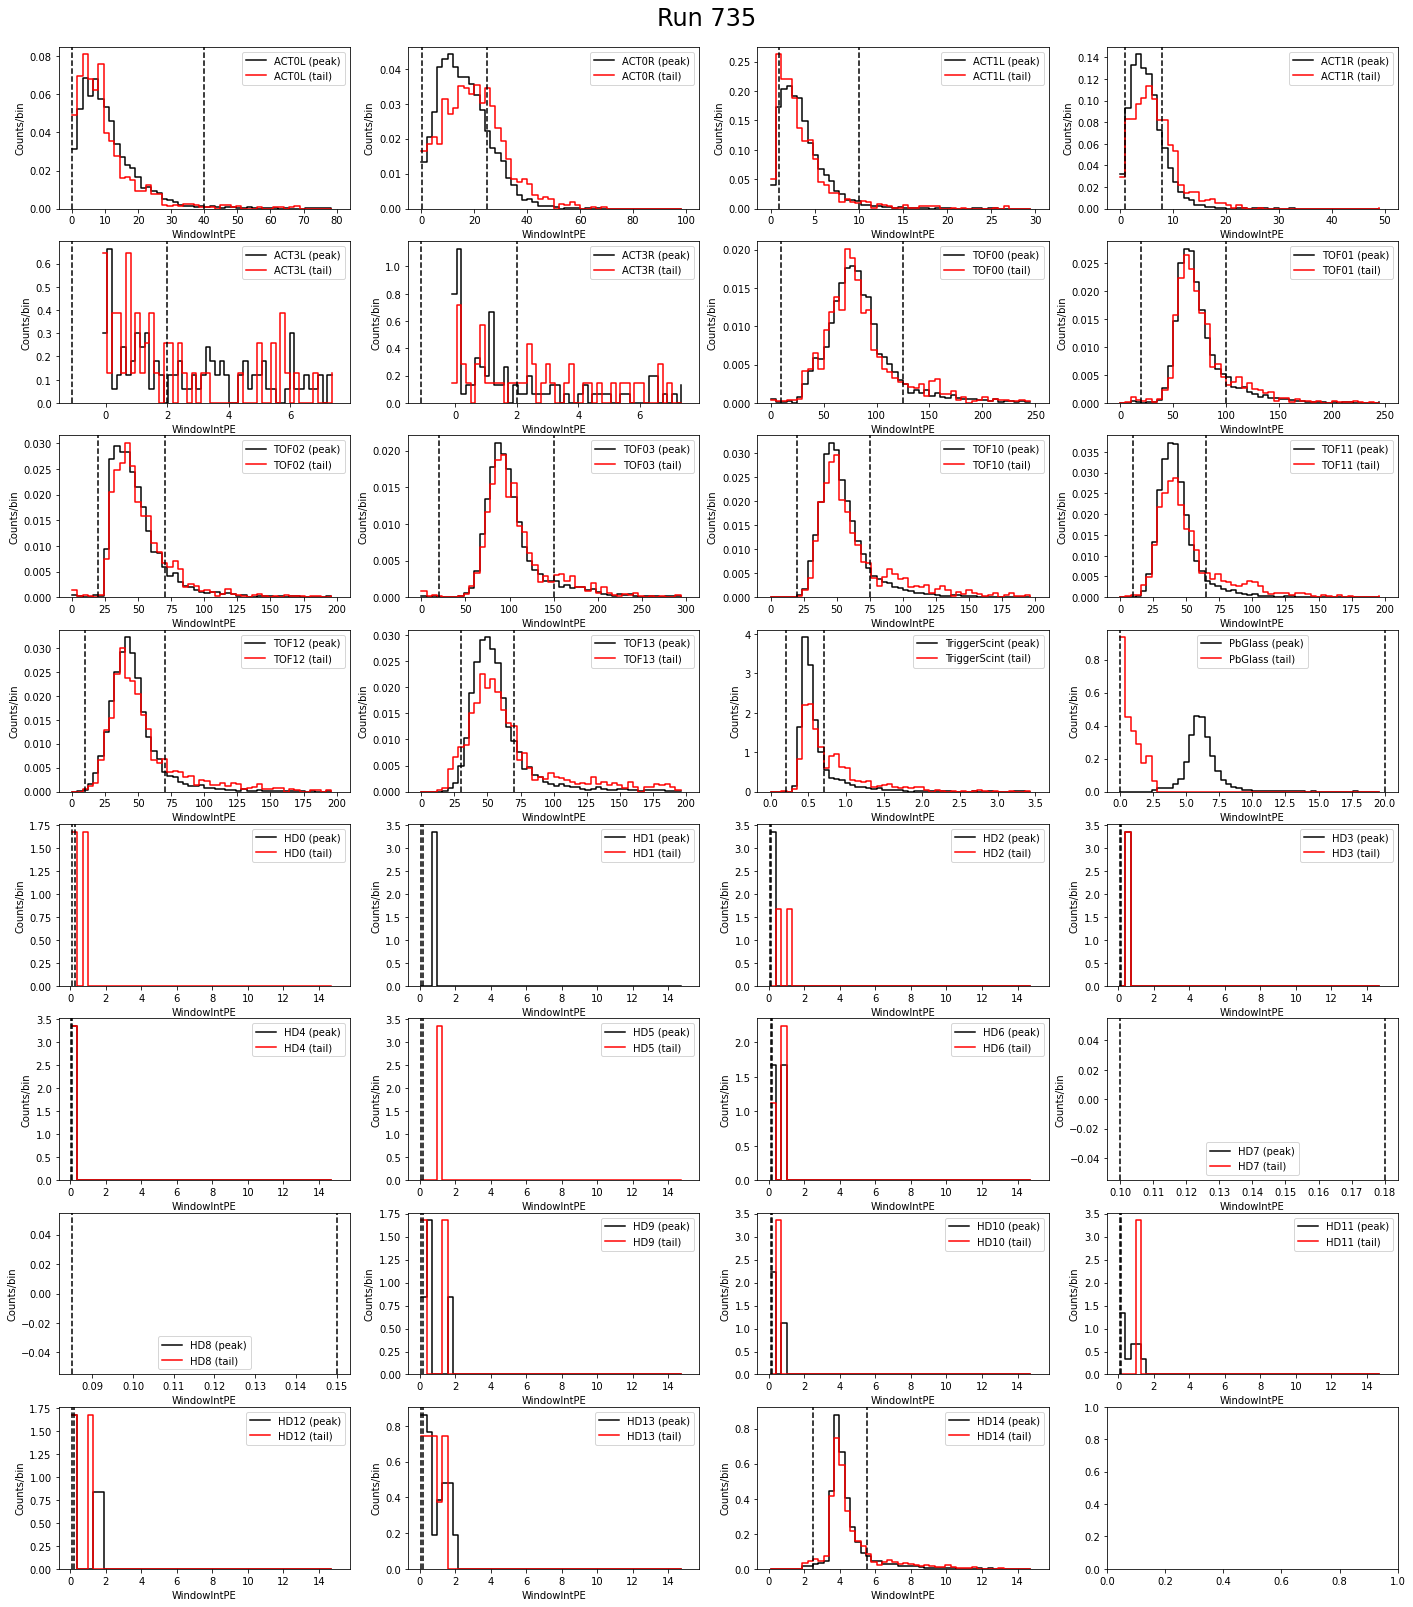

In [64]:
# Reload charge cuts if necessary.
reload_constants()

# Assign the charge cuts
chg_cuts = chg_cuts_tight
chg_range = chg_ranges_wide

hd.plot_charge_histograms(df_dict, 'WindowIntPE', chg_cuts, chg_range, rnum, nbins = 50, evt_list = evt_list_PEAK, lbl = 'peak', evt_list_2 = evt_list_TAIL, lbl_2 = 'tail', select_nonzero_peaks = True, normed = True, logscale = False)

In [65]:
df_tightcuts, _, _, _ = hd.charge_analysis_corrected_winInt(df_dict, chg_cuts_tight)

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Charge cut table (*tbl.timingcuts*)

In [66]:
# Print timing cut table
cuts_hd14      = (df_tightcuts.hit_HD14 == 1)
cuts_hd14_tail = cuts_hd14 & (df_tightcuts.LG_WindowIntPE <  tail_threshold) & (final_df.LG_WindowIntPE > 1.0)
cuts_hd14_peak = cuts_hd14 & (df_tightcuts.LG_WindowIntPE >= tail_threshold)

# Total numbers of events
tot_hd14 = len(df_tightcuts[cuts_hd14])
tot_hd14_peak = len(df_tightcuts[cuts_hd14_peak])
tot_hd14_tail = len(df_tightcuts[cuts_hd14_tail])

# Cuts to evaluate
cuts_ACT0      = (df_tightcuts.hit_ACT0 == 1)
cuts_ACT1      = (df_tightcuts.hit_ACT1 == 1)
cuts_ACT3      = (df_tightcuts.nohit_ACT3 == 1)
cuts_TOF0      = (df_tightcuts.hit_TOF0 == 1)
cuts_TOF1      = (df_tightcuts.hit_TOF1 == 1)
cuts_T2        = (df_tightcuts.hit_T2 == 1)
cuts_all       = cuts_ACT0 & cuts_ACT1 & cuts_TOF0 & cuts_TOF1 & cuts_T2 & cuts_ACT3

# Arrays for iterating through the cuts
cuts_txt = ["HD14 hit only", "ACT0 hit", "ACT1 hit", "ACT3 no hit", "TOF0 hit", "TOF1 hit", "T2 hit", "All"]
cuts_arr = [cuts_hd14, cuts_ACT0, cuts_ACT1, cuts_ACT3, cuts_TOF0, cuts_TOF1, cuts_T2, cuts_all]

print("Cut & All evts (\\%) & Peak evts (\\%) & Tail evts (\\%)\\\\")
print("\hline")
for txt,cuts in zip(cuts_txt,cuts_arr):
    nall  = len(df_tightcuts[cuts_hd14 & cuts])
    npeak = len(df_tightcuts[cuts_hd14_peak & cuts])
    ntail = len(df_tightcuts[cuts_hd14_tail & cuts])
    
    print(f"{txt} & {nall} ({nall/tot_hd14*100:.0f}) & {npeak} ({npeak/tot_hd14_peak*100:.0f}) & {ntail} ({ntail/tot_hd14_tail*100:.0f})\\\\")

Cut & All evts (\%) & Peak evts (\%) & Tail evts (\%)\\
\hline
HD14 hit only & 5221 (100) & 4251 (100) & 793 (100)\\
ACT0 hit & 5182 (99) & 4227 (99) & 781 (98)\\
ACT1 hit & 4919 (94) & 4072 (96) & 695 (88)\\
ACT3 no hit & 4967 (95) & 4055 (95) & 749 (94)\\
TOF0 hit & 4850 (93) & 3970 (93) & 718 (91)\\
TOF1 hit & 4704 (90) & 3927 (92) & 627 (79)\\
T2 hit & 4040 (77) & 3484 (82) & 455 (57)\\
All & 3187 (61) & 2826 (66) & 298 (38)\\


/var/folders/05/5x88pkbj3yb7x2vwsxtwvmdm0000gn/T/ipykernel_36745/3693449422.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tot_hd14_tail = len(df_tightcuts[cuts_hd14_tail])
/var/folders/05/5x88pkbj3yb7x2vwsxtwvmdm0000gn/T/ipykernel_36745/3693449422.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ntail = len(df_tightcuts[cuts_hd14_tail & cuts])


Initial params: [330, 420.01291853902296, 87.70992929016546]


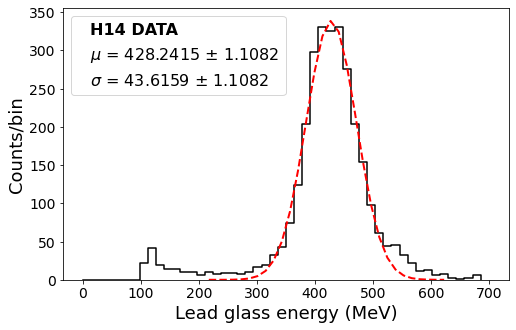

In [67]:
hd.plot_HD14_peak(df_tightcuts, e_range = [0, 700], ecal_m = 1.86e-2, ecal_b = -1.89, nbins = 50, fit_start = 15, fit_end = 45, normed = False, energy_cut = 50, low_radiation = False)

# Additional code: data processing

### Create dataframes for all runs

In [ ]:
ntuple_dir = "/home/jrenner/local/jerenner/T9BeamTestAna/ntuple/"
ntuple_pd_dir = "/home/jrenner/local/jerenner/T9BeamTestAna/ntuple_dataframes/"
windowInt = True

In [ ]:
#runs = np.arange(630,766)
runs = [731, 732, 733, 734, 735, 736, 737, 738, 753, 754, 755, 756, 760, 763, 764, 765]
for run in runs:
    ntuple_file = "{}/WindowIntMatched_final_000{}.root".format(ntuple_dir,run)
    output_dir = "{}/run000{}".format(ntuple_pd_dir,run)
    
    # Make sure the file exists
    if(not os.path.isfile(ntuple_file)):
        continue
    
    print("Creating dataframes for run",run,"...")
    
    # Create the dataframe dictionary
    df_dict = hd.ntuple_to_pd_multipeak(ntuple_file,windowInt=windowInt)

    # Save all the dataframes for this run
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for key, df in df_dict.items():
        filepath = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(filepath, index=False)

### Plot all quantities for each signal for each run

In [ ]:
runs = [735] #np.arange(786,788)
for run in runs:
    rnum = f"000{run}"
    run_dir = "{}/run{}".format(ntuple_pd_dir, rnum)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)
    
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='timeStamp', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='triggerTime', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='Pedestal', windowInt=windowInt, select_nonzero_peaks=False, logscale=True, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PedestalSigma', windowInt=windowInt, select_nonzero_peaks=False, logscale=True, nbins=60)
    
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='MaxVoltage', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WholeWaveformInt', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WholeWaveformIntPE', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
    
    if(windowInt):
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nWindowPeaks', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeMatchedTOF0', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeMatchedTOF1', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowIntCharge', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowIntPE', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowWidth', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowLowerTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowUpperTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowCentralTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='WindowCentralTimeCorrected', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
    else:
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nPeaks', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=20)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakVoltage', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=40)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTime', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTimeCorrected', windowInt=windowInt, select_nonzero_peaks=False, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntCharge', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)
        hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntPE', windowInt=windowInt, select_nonzero_peaks=True, logscale=False, nbins=60)

## Compute and plot statistics for each run

In [ ]:
statistics_data = {}

runs = np.arange(630,766)
for run in runs:
    run_dir = "{}/run000{}".format(ntuple_pd_dir, run)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)
    
    # Compute statistics for this run and save them
    statistics_data[run] = {}
    for key in custom_order:
        statistics_data[run][key] = hd.compute_statistics(df_dict[key])

#### Plot summary statistics from each run

In [ ]:
statistics_keys = ['avg_nPeaks', 'avg_Pedestal', 'avg_PedestalSigma', 'peak_PeakVoltage', 'peak_PeakTime', 'peak_SignalTime', 'peak_IntCharge']
act_set = ['ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R', 'PbGlass']
tof_set = ['TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13', 'TriggerScint']
hd_set  = ['HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14']

hd.plot_statistics_vs_run(statistics_data, statistics_keys, act_set, base_dir='plt', signal_set_name='ACT')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, tof_set, base_dir='plt', signal_set_name='TOF')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, hd_set, base_dir='plt', signal_set_name='HD')

---